In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 200)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Import additional libraries
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import KNNImputer
from scipy.stats import kstest, pearsonr, spearmanr, zscore

In [2]:
# Load the dataset
df = pd.read_excel('_data/_matches_list_v3.xlsx')

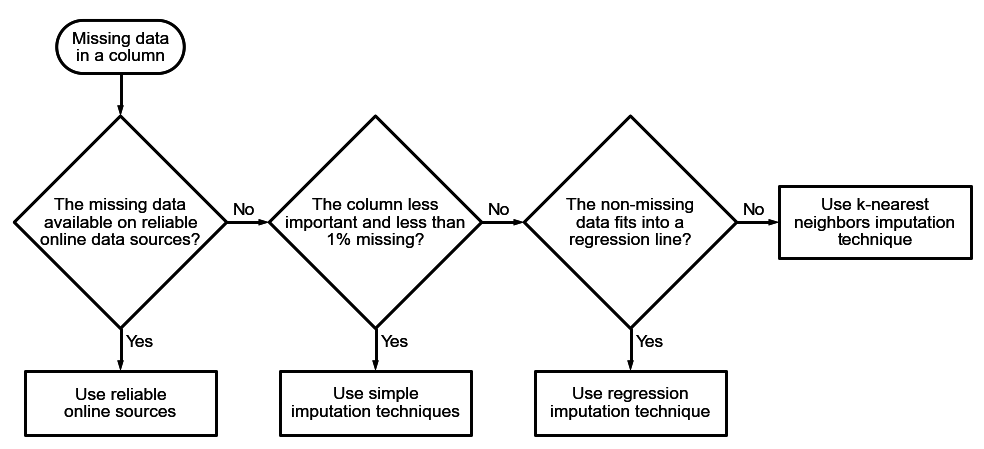

In [3]:
import schemdraw
from schemdraw import flow

with schemdraw.Drawing() as d:
    # Start with missing data in a column
    start = flow.Start(w=3).label("Missing data\nin a column")
    d += start
    d += flow.Arrow().down().length(d.unit/3).at(start.S)
    #d += flow.Arrow().right().length(d.unit/4).at(start.E)

    # Decision-1
    d += (decision1 := flow.Decision(w=5, h=5, E="No", S="Yes").label("The missing data\navailable on reliable\nonline data sources?"))

    # Decision-1 Yes path
    d += flow.Arrow().down(d.unit/3).at(decision1.S)
    d += (fill_values := flow.Box(w=4.5, h=1.5).label("Use reliable\nonline sources"))

    # Decision-1 No path
    d += flow.Arrow().right(d.unit/3).at(decision1.E)
    d += (decision2 := flow.Decision(w=5, h=5, E="No", S="Yes").label("The column less\nimportant and less than\n1% missing?"))
    
    # Decision-2 Yes path
    d += flow.Arrow().down(d.unit/3).at(decision2.S)
    d += (simple_imp := flow.Box(w=4.5, h=1.5).label("Use simple\nimputation techniques"))
    
    # Decision-2 No path
    d += flow.Arrow().right(d.unit/3).at(decision2.E)
    d += (decision3 := flow.Decision(w=5, h=5, E="No", S="Yes").label("The non-missing\ndata fits into a\nregression line?"))
    
    # Decision-3 Yes path
    d += flow.Arrow().down(d.unit/3).at(decision3.S)
    d += (reg_imp := flow.Box(w=4.5, h=1.5).label("Use regression\nimputation technique"))
    
    # Decision-3 No path
    d += flow.Arrow().right(d.unit/3).at(decision3.E)
    d += (knn_imp := flow.Box(w=4.5, h=1.7).label("Use k-nearest\nneighbors imputation\ntechnique"))

    d.save('_images/missing_data_flowchart.png')


In [4]:
def check_df(df):
    print("="*30 + " Shape " + "="*30)
    print(df.shape)
    print("\n" + "="*30 + " Unique Values " + "="*30)
    print(df.nunique())
    print("\n" + "="*30 + " Info " + "="*30)
    print(df.info())
    print("\n" + "="*30 + " Duplicated " + "="*30)
    print(df.duplicated().sum())
    print("\n" + "="*30 + " Missing " + "="*30)
    display(pd.DataFrame(df.isnull().sum(), columns=['Missing']).sort_values(by='Missing', ascending=False))
    print("\n" + "="*30 + " Describe " + "="*30)
    display(df.describe().transpose())
    print("\n" + "="*30 + " Quantiles " + "="*30)
    try:
        display(df.quantile([0.00, 0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1.00]).transpose())
    except:
        pass

check_df(df)

============================== Shape ==============================
(34121, 63)

============================== Unique Values ==============================
match_id         34121
match_date        3848
year                14
tourney_name       114
tourney_level        4
court                2
surface              3
draw_size            9
round                8
best_of              2
minutes            277
total_points       372
total_games         69
score             6447
p1_won               2
p1_points          216
p2_points          214
p1_games            44
p2_games            44
p1_sets              4
p2_sets              4
p1_id              808
p2_id              826
p1_name            809
p2_name            827
p1_rank            678
p2_rank            666
p1_rankpt         2991
p2_rankpt         2994
p1_hand              4
p2_hand              3
p1_ht               26
p2_ht               25
p1_ioc              70
p2_ioc              74
p1_age             249
p2_age         

,Missing
p1_entry,27718
p2_entry,27471
p1_seed,21578
p2_seed,21567
minutes,1390
p2_ht,151
p1_ht,103
p1_Avg,51
p2_Max,51
p1_Max,51



============================== Describe ==============================


,count,mean,std,min,25%,50%,75%,max
year,34121.00,2015.29,4.02,2009.00,2012.00,2015.00,2019.00,2022.00
draw_size,34121.00,61.17,39.53,8.00,32.00,32.00,96.00,128.00
best_of,34121.00,3.39,0.79,3.00,3.00,3.00,3.00,5.00
minutes,32731.00,110.78,41.26,28.00,80.00,103.00,133.00,1146.00
total_points,34103.00,161.97,55.76,25.00,119.00,151.00,193.00,980.00
total_games,34121.00,25.81,8.55,12.00,19.00,24.00,31.00,183.00
p1_won,34121.00,0.50,0.50,0.00,0.00,1.00,1.00,1.00
p1_points,34103.00,80.99,29.11,10.00,61.00,76.00,98.00,478.00
p2_points,34103.00,80.98,29.08,13.00,61.00,76.00,97.00,502.00
p1_games,34121.00,12.91,5.14,0.00,10.00,13.00,16.00,92.00



============================== Quantiles ==============================


,0.00,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99,1.00
year,2009.00,2009.00,2009.00,2010.00,2012.00,2015.00,2019.00,2021.00,2022.00,2022.00,2022.00
draw_size,8.00,28.00,28.00,28.00,32.00,32.00,96.00,128.00,128.00,128.00,128.00
best_of,3.00,3.00,3.00,3.00,3.00,3.00,3.00,5.00,5.00,5.00,5.00
minutes,28.00,52.00,61.00,67.00,80.00,103.00,133.00,163.00,187.00,239.00,1146.00
total_points,25.00,82.00,95.00,102.00,119.00,151.00,193.00,232.00,270.00,339.00,980.00
total_games,12.00,14.00,16.00,17.00,19.00,24.00,31.00,36.00,43.00,53.00,183.00
p1_won,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
p1_points,10.00,31.00,41.00,48.00,61.00,76.00,98.00,117.00,136.00,171.00,478.00
p2_points,13.00,31.00,41.00,48.00,61.00,76.00,97.00,117.00,136.00,171.00,502.00
p1_games,0.00,3.00,5.00,6.00,10.00,13.00,16.00,19.00,22.00,27.00,92.00


##### Impute Missing Age Values #####

In [5]:
# Print the number of distinct players and matches for missing 'p1_age' and 'p2_age'
def print_missing_age_values(df):
    missing_age_players = pd.concat([df[df['p1_age'].isnull()]['p1_name'], df[df['p2_age'].isnull()]['p2_name']]).unique()
    missing_age_matches = pd.concat([df[df['p1_age'].isnull()]['match_id'], df[df['p2_age'].isnull()]['match_id']]).unique()
    print("Number of missing distinct players:", len(missing_age_players))
    print("Number of missing distinct matches:", len(missing_age_matches))
    print("\n")

print_missing_age_values(df)

# Filter df where 'p1_age' or 'p2_age' is missing
missing_p1_age_df = df[df['p1_age'].isnull()][['match_date', 'p1_name']]
missing_p2_age_df = df[df['p2_age'].isnull()][['match_date', 'p2_name']]

# Define the index of the row where 'p1_age' or 'p2_age' is missing
missing_age_index = missing_p1_age_df.index[0] if not missing_p1_age_df.empty else missing_p2_age_df.index[0]

# Calculate the age in years rounded to 2 decimal places
age_in_years = round((pd.Timestamp('2022-10-10') - pd.Timestamp('2005-09-19')).days / 365, 1)

# Update the 'p1_age' or 'p2_age' in df with the calculated age in years (rounded)
if not missing_p1_age_df.empty:
    df.at[missing_age_index, 'p1_age'] = age_in_years
elif not missing_p2_age_df.empty:
    df.at[missing_age_index, 'p2_age'] = age_in_years

print_missing_age_values(df)

print("Imputed value: ", age_in_years)


Number of missing distinct players: 1
Number of missing distinct matches: 1


Number of missing distinct players: 0
Number of missing distinct matches: 0


Imputed value:  17.1


##### Impute Missing Rank and Rankpt Values #####

In [6]:
# Print the number of distinct players and matches for missing 'p1_rank' and 'p2_rank'
def print_missing_rank_values(df):
    missing_rank_players = pd.concat([df[df['p1_rank'].isnull()]['p1_name'], df[df['p2_rank'].isnull()]['p2_name']]).unique()
    missing_rank_matches = pd.concat([df[df['p1_rank'].isnull()]['match_id'], df[df['p2_rank'].isnull()]['match_id']]).unique()
    print("Number of missing distinct players:", len(missing_rank_players))
    print("Number of missing distinct matches:", len(missing_rank_matches))
    print("\n")

print_missing_rank_values(df)

# Filter and print p2_rank and p2_rankpt columns of rows with maximum p2_rank
display(df[df['p1_rank'] == df['p1_rank'].max()][['p1_rank', 'p1_rankpt']])
display(df[df['p2_rank'] == df['p2_rank'].max()][['p2_rank', 'p2_rankpt']])

# Fill missing values in p1_rank and p2_rank columns with 2200
df['p1_rank'] = df['p1_rank'].fillna(2200)
df['p2_rank'] = df['p2_rank'].fillna(2200)

# Fill missing values in p1_rankpt and p2_rankpt columns with 0
df['p1_rankpt'] = df['p1_rankpt'].fillna(0)
df['p2_rankpt'] = df['p2_rankpt'].fillna(0)


Number of missing distinct players: 58
Number of missing distinct matches: 87




,p1_rank,p1_rankpt
31535,2146.00,1.00


,p2_rank,p2_rankpt
14300,2159.00,1.00


##### Impute Missing Seed Values #####

In [7]:
# Print the number of distinct players and matches for missing 'p1_seed' and 'p2_seed'
def print_missing_seed_values(df):
    missing_seed_players = pd.concat([df[df['p1_seed'].isnull()]['p1_name'], df[df['p2_seed'].isnull()]['p2_name']]).unique()
    missing_seed_matches = pd.concat([df[df['p1_seed'].isnull()]['match_id'], df[df['p2_seed'].isnull()]['match_id']]).unique()
    print("Number of missing distinct players:", len(missing_seed_players))
    print("Number of missing distinct matches:", len(missing_seed_matches))
    print("\n")

print_missing_seed_values(df)

# Group by 'year' and 'tourney_name' and calculate the max seeds
grouped = df.groupby(['year', 'tourney_name']).agg({
    'p1_seed': 'max',
    'p2_seed': 'max',
    'draw_size': 'first'
}).reset_index()

# Calculate the max seed across both 'p1_seed' and 'p2_seed'
grouped['max_seed'] = grouped[['p1_seed', 'p2_seed']].max(axis=1, skipna=True)
grouped['max_seed'].fillna(0, inplace=True)

# Calculate the imputed seed value
grouped['imputed_seed'] = (grouped['draw_size'] - grouped['max_seed']) / 2

# Merge the imputed seed value back into the original DataFrame
df = pd.merge(df, grouped[['year', 'tourney_name', 'imputed_seed']], on=['year', 'tourney_name'], how='left')

# Impute the missing 'p1_seed' and 'p2_seed' values
df['p1_seed'].fillna(df['imputed_seed'], inplace=True)
df['p2_seed'].fillna(df['imputed_seed'], inplace=True)

# Drop the 'imputed_seed' column as it's no longer needed
df.drop('imputed_seed', axis=1, inplace=True)


Number of missing distinct players: 942
Number of missing distinct matches: 30243




##### Impute Missing Hand Values #####

In [8]:
# Transform 'U' and 'A' values in p1_hand and p2_hand columns into NaN
df['p1_hand'] = df['p1_hand'].replace(['U', 'A'], np.nan)
df['p2_hand'] = df['p2_hand'].replace(['U', 'A'], np.nan)

In [9]:
# Print the number of distinct players and matches for missing 'p1_hand' and 'p2_hand'
def print_missing_hand_values(df):
    missing_hand_players = pd.concat([df[df['p1_hand'].isnull()]['p1_name'], df[df['p2_hand'].isnull()]['p2_name']]).unique()
    missing_hand_matches = pd.concat([df[df['p1_hand'].isnull()]['match_id'], df[df['p2_hand'].isnull()]['match_id']]).unique()
    print("Number of missing distinct players:", len(missing_hand_players))
    print("Number of missing distinct matches:", len(missing_hand_matches))
    print("\n")

print_missing_hand_values(df)

# Define a dictionary with player names as keys and hand as values
hand_dict = {
    "Kevin King": "L", "Romain Bogaerts": "L", "Lucas Gomez": "L", 
    "Ryan Peniston": "L", "Learner Tien": "L", "Ludovic Walter": "L", 
    "Tigre Hank": "L", "Abdulla Hajji": "R", "Yew Ming Si": "R", 
    "Guillermo Olaso": "R", "Yassine Idmbarek": "R", "Walter Trusendi": "R", 
    "Nicolas Meister": "R", "Clement Reix": "R", "Philip Davydenko": "R", 
    "Mousa Shanan Zayed": "R", "Edward Corrie": "R", "Nathan Pasha": "R", 
    "Xin Gao": "R", "Eric Quigley": "R", "Alejandro Gomez Gb42": "R", 
    "Ryan Shane": "R", "Oliver Anderson": "R", "Jordi Samper Montana": "R", 
    "Mubarak Shannan Zayid": "R", "Blake Mott": "R", "Jose Hernandez": "R", 
    "Nino Serdarusic": "R", "Gerardo Lopez Villasenor": "R", "Altug Celikbilek": "R", 
    "Raul Brancaccio": "R", "Flavio Cobolli": "R", "Vit Kopriva": "R", 
    "Alexander Erler": "R", "Sam Riffice": "R", "Andrea Vavassori": "R", 
    "Caleb Chakravarthi": "R", "Max Hans Rehberg": "R", "Carlos Gimeno Valero": "R", 
    "Manuel Guinard": "R", "William Blumberg": "R", "Andres Martin": "R", 
    "Rinky Hijikata": "R", "Aleksandar Kovacevic": "R", "Francesco Maestrelli": "R", 
    "Rabie Chaki": "R", "Sherif Sabry": "R", "Alexander Ward": "R", 
    "Martin Vaisse": "R", "Daniel Smethurst": "R", "Takuto Niki": "R", 
    "Amine Ahouda": "R", "Edan Leshem": "R", "Petros Tsitsipas": "R", 
    "Marko Topo": "R", "Nicolas Alvarez Varona": "R", "Mili Poljicak": "R", 
    "Hernan Casanova": "R", "Yunseong Chung": "R", "Rio Noguchi": "R", 
    "Sho Shimabukuro": "R"
}

# Update the missing 'p1_hand' and 'p2_hand' values with the values from the dictionary
df.loc[df['p1_name'].isin(hand_dict.keys()) & df['p1_hand'].isnull(), 'p1_hand'] = df['p1_name'].map(hand_dict)
df.loc[df['p2_name'].isin(hand_dict.keys()) & df['p2_hand'].isnull(), 'p2_hand'] = df['p2_name'].map(hand_dict)

print_missing_hand_values(df)

# Mode impute the missing 'p1_hand' and 'p2_hand'
df['p1_hand'].fillna(df['p1_hand'].mode()[0], inplace=True)
df['p2_hand'].fillna(df['p2_hand'].mode()[0], inplace=True)

print_missing_hand_values(df)

# Combine 'p1_hand' and 'p2_hand' into a single series
combined_hand = pd.concat([df['p1_hand'], df['p2_hand']])

# Calculate the percentage of R and L values
percentage_R = (combined_hand.value_counts()['R'] / combined_hand.count()) * 100
percentage_L = (combined_hand.value_counts()['L'] / combined_hand.count()) * 100

print("Percentage of R values: ", round(percentage_R, 2))
print("Percentage of L values: ", round(percentage_L, 2))
print("Imputed value: ", df['p1_hand'].mode()[0])


Number of missing distinct players: 65
Number of missing distinct matches: 133


Number of missing distinct players: 4
Number of missing distinct matches: 7


Number of missing distinct players: 0
Number of missing distinct matches: 0


Percentage of R values:  86.1
Percentage of L values:  13.9
Imputed value:  R


##### Impute Missing Height Values #####

In [10]:
# Print the number of missing values in 'p1_ht' and 'p2_ht' columns
def print_missing_height_values(df):
    missing_height_players = pd.concat([df[df['p1_ht'].isnull()]['p1_name'], df[df['p2_ht'].isnull()]['p2_name']]).unique()
    missing_height_matches = pd.concat([df[df['p1_ht'].isnull()]['match_id'], df[df['p2_ht'].isnull()]['match_id']]).unique()
    print("Number of missing distinct players:", len(missing_height_players))
    print("Number of missing distinct matches:", len(missing_height_matches))
    print("\n")

print_missing_height_values(df)

# Define a dictionary with player names as keys and height as values
ht_dict = {
    "Fritz Wolmarans": 198,
    "Manuel Guinard": 198,
    "Clay Thompson": 198,
    "Beibit Zhukayev": 196,
    "Francesco Maestrelli": 196,
    "Eduardo Struvay": 196,
    "Nicolas Renavand": 193,
    "Sebastian Rieschick": 193,
    "Marko Tepavac": 193,
    "Alastair Gray": 193,
    "Ben Shelton": 193,
    "Alexander Ritschard": 193,
    "Victor Baluda": 193,
    "Evgenii Tiurnev": 191,
    "Gijs Brouwer": 191,
    "Santiago Fa Rodriguez Taverna": 191,
    "Dragos Nicolae Madaras": 191,
    "Carlos Gimeno Valero": 191,
    "Ivan Gakhov": 191,
    "Mikhail Biryukov": 190,
    "Luka Gregorc": 190,
    "Petar Jelenic": 190,
    "Rameez Junaid": 190,
    "Ludovic Walter": 190,
    "Phillip Simmonds": 190,
    "Cole Gromley": 190,
    "Mohammad Ghareeb": 188,
    "Alen Avidzba": 188,
    "Caleb Chakravarthi": 188,
    "Nicolas Alvarez Varona": 188,
    "William Blumberg": 188,
    "Franco Agamenone": 188,
    "Yew Ming Si": 188,
    "Kristijan Mesaros": 188,
    "Romain Bogaerts": 188,
    "Marko Djokovic": 187,
    "Clement Reix": 186,
    "Lars Poerschke": 185,
    "Javier Marti": 185,
    "Nikolai Fidirko": 185,
    "Boy Westerhof": 185,
    "Takanyi Garanganga": 185,
    "Andrea Basso": 185,
    "Alibek Kachmazov": 185,
    "Camilo Ugo Carabelli": 185,
    "Mili Poljicak": 185,
    "Austin Smith": 185,
    "Alexander Shevchenko": 185,
    "Brandon Holt": 185,
    "Matteo Trevisan": 183,
    "Max Hans Rehberg": 183,
    "Ryan Peniston": 183,
    "Andres Martin": 183,
    "Aleksandar Kovacevic": 183,
    "Felipe Rios": 183,
    "Pablo Galdon": 183,
    "Evgeny Kirillov": 183,
    "Suk Young Jeong": 183,
    "Andres Artunedo Martinavarro": 183,
    "Facundo Mena": 183,
    "Sho Shimabukuro": 183,
    "Jordi Samper Montana": 182,
    "Martin Vaisse": 180,
    "N Vijay Sundar Prashanth": 180,
    "Eduardo Nava": 180,
    "Juncheng Shang": 180,
    "Francesco Passaro": 180,
    "Jesper De Jong": 180,
    "Filip Misolic": 180,
    "Learner Tien": 180,
    "Gilles Arnaud Bailly": 180,
    "Jabor Al Mutawa": 180,
    "Patrick Ciorcila": 180,
    "Michael Linzer": 180,
    "Enrique Lopez Perez": 180,
    "Alexis Galarneau": 180,
    "Luca Van Assche": 180,
    "Colin Ebelthite": 179,
    "Dennis Lajola": 179,
    "Todd Widom": 178,
    "Cristobal Saavedra Corvalan": 178,
    "Jack Mingjie Lin": 178,
    "Hernan Casanova": 178,
    "Nick Chappell": 178,
    "Germain Gigounon": 178,
    "Rinky Hijikata": 178,
    "Yunseong Chung": 178,
    "Kento Takeuchi": 177,
    "Shintaro Mochizuki": 175,
    "Juan Alejandro Hernandez Serrano": 175,
    "Seong Chan Hong": 175,
    "Karim Maamoun": 175,
    "James Lemke": 175,
    "Peerakiat Siriluethaiwattana": 175,
    "Oliver Anderson": 175,
    "Gonzalo Villanueva": 175,
    "Flavio Cobolli": 173,
    "Sascha Kloer": 173,
    "Evan Furness": 173,
    "Daniel Garza": 171,
    "Rio Noguchi": 168,
    "Mehdi Ziadi": 158
}

# Update the missing 'p1_ht' and 'p2_ht' values with the values from the dictionary
df.loc[df['p1_name'].isin(ht_dict.keys()) & df['p1_ht'].isnull(), 'p1_ht'] = df['p1_name'].map(ht_dict)
df.loc[df['p2_name'].isin(ht_dict.keys()) & df['p2_ht'].isnull(), 'p2_ht'] = df['p2_name'].map(ht_dict)

print_missing_height_values(df)

# Combine 'p1_ht' and 'p2_ht' into one Series
combined_ht = pd.concat([df['p1_ht'], df['p2_ht']])

# Calculate the median of 'combined_ht'
median_combined_ht = combined_ht.median()

# Impute missing 'p1_ht' and 'p2_ht' values by 'median_combined_ht'
df['p1_ht'].fillna(median_combined_ht, inplace=True)
df['p2_ht'].fillna(median_combined_ht, inplace=True)

print_missing_height_values(df)

print("Imputed value: ", median_combined_ht)

Number of missing distinct players: 129
Number of missing distinct matches: 253


Number of missing distinct players: 27
Number of missing distinct matches: 41


Number of missing distinct players: 0
Number of missing distinct matches: 0


Imputed value:  185.0


##### Impute Missing Statistics #####

In [11]:
# Add a new column indicating whether 'p1_ace' is missing
df['stats_missing'] = df['p1_ace'].isnull()

# Print the number of missing values in 'stats_missing' column
print("Number of missing distinct matches:", df['stats_missing'].sum())

display(df[df['stats_missing'] == True][['match_id', 'score', 'p1_won', 'year', 'tourney_name', 'p1_name', 'p2_name']])

Number of missing distinct matches: 18


,match_id,score,p1_won,year,tourney_name,p1_name,p2_name
198,2009-580-0028,5-7 3-6 6-4 6-3 6-4,0,2009,Australian Open,Peter Polansky,Igor Andreev
215,2009-580-0093,6-3 6-4 6-4,0,2009,Australian Open,Brydan Klein,Stan Wawrinka
1603,2009-316-0002,6-0 6-4,0,2009,Bastad,Denis Istomin,Victor Crivoi
1604,2009-316-0006,4-6 6-1 6-0,1,2009,Bastad,Teymuraz Gabashvili,Christophe Rochus
1708,2009-414-0035,7-5 6-3,1,2009,Hamburg,Nicolas Almagro,Robin Soderling
14606,2014-421-0022,6-2 4-6 7-5,0,2014,Canada Masters,Denis Istomin,Marin Cilic
16980,2015-6116-0004,3-6 6-4 7-6(5),1,2015,Atlanta,Denis Kudla,Ryan Harrison
18118,2016-7161-0300,4-6 7-6(5) 6-2,0,2016,Quito,Thomaz Bellucci,Victor Estrella
20443,2017-M001-0270,6-3 7-6(6),0,2017,Sydney,Viktor Troicki,Gilles Muller
20444,2017-M001-0271,6-2 3-6 6-3,1,2017,Sydney,Daniel Evans,Andrey Kuznetsov


In [12]:
### (tennislive.net is the source)
# Define a dictionary with match_id as keys and stats as values 
stats_dict = {
    "2009-580-0028": {'p1_ace': 7, 'p2_ace': 13, 'p1_df': 4, 'p2_df': 7, 'p1_svpt': 165, 'p2_svpt': 136, 'p1_1stIn': 101, 'p2_1stIn': 80, 'p1_1stWon': 63, 'p2_1stWon': 66, 'p1_2ndWon': 35, 'p2_2ndWon': 26, 'p1_SvGms': 25, 'p2_SvGms': 25, 'p1_bpSaved': 6, 'p2_bpSaved': 5, 'p1_bpFaced': 12, 'p2_bpFaced': 10},
    "2009-580-0093": {'p1_ace': 8, 'p2_ace': 4, 'p1_df': 4, 'p2_df': 3, 'p1_svpt': 100, 'p2_svpt': 81, 'p1_1stIn': 67, 'p2_1stIn': 49, 'p1_1stWon': 47, 'p2_1stWon': 38, 'p1_2ndWon': 15, 'p2_2ndWon': 24, 'p1_SvGms': 14, 'p2_SvGms': 15, 'p1_bpSaved': 7, 'p2_bpSaved': 1, 'p1_bpFaced': 10, 'p2_bpFaced': 1},
    "2009-316-0002": {'p1_ace': 2, 'p2_ace': 2, 'p1_df': 1, 'p2_df': 5, 'p1_svpt': 61, 'p2_svpt': 62, 'p1_1stIn': 33, 'p2_1stIn': 36, 'p1_1stWon': 17, 'p2_1stWon': 25, 'p1_2ndWon': 11, 'p2_2ndWon': 13, 'p1_SvGms': 8, 'p2_SvGms': 8, 'p1_bpSaved': 9, 'p2_bpSaved': 3, 'p1_bpFaced': 14, 'p2_bpFaced': 4},
    "2009-316-0006": {'p1_ace': 7, 'p2_ace': 1, 'p1_df': 7, 'p2_df': 5, 'p1_svpt': 85, 'p2_svpt': 74, 'p1_1stIn': 49, 'p2_1stIn': 40, 'p1_1stWon': 31, 'p2_1stWon': 23, 'p1_2ndWon': 19, 'p2_2ndWon': 10, 'p1_SvGms': 12, 'p2_SvGms': 11, 'p1_bpSaved': 9, 'p2_bpSaved': 4, 'p1_bpFaced': 12, 'p2_bpFaced': 11},
    "2009-414-0035": {'p1_ace': 7, 'p2_ace': 2, 'p1_df': 0, 'p2_df': 3, 'p1_svpt': 54, 'p2_svpt': 80, 'p1_1stIn': 34, 'p2_1stIn': 54, 'p1_1stWon': 28, 'p2_1stWon': 36, 'p1_2ndWon': 14, 'p2_2ndWon': 12, 'p1_SvGms': 10, 'p2_SvGms': 11, 'p1_bpSaved': 3, 'p2_bpSaved': 11, 'p1_bpFaced': 3, 'p2_bpFaced': 14},
    "2014-421-0022": {'p1_ace': 5, 'p2_ace': 5, 'p1_df': 3, 'p2_df': 2, 'p1_svpt': 109, 'p2_svpt': 76, 'p1_1stIn': 62, 'p2_1stIn': 43, 'p1_1stWon': 37, 'p2_1stWon': 36, 'p1_2ndWon': 23, 'p2_2ndWon': 18, 'p1_SvGms': 15, 'p2_SvGms': 15, 'p1_bpSaved': 12, 'p2_bpSaved': 1, 'p1_bpFaced': 17, 'p2_bpFaced': 4},
    "2015-6116-0004": {'p1_ace': 4, 'p2_ace': 12, 'p1_df': 5, 'p2_df': 3, 'p1_svpt': 87, 'p2_svpt': 98, 'p1_1stIn': 51, 'p2_1stIn': 63, 'p1_1stWon': 40, 'p2_1stWon': 48, 'p1_2ndWon': 19, 'p2_2ndWon': 17, 'p1_SvGms': 16, 'p2_SvGms': 16, 'p1_bpSaved': 3, 'p2_bpSaved': 4, 'p1_bpFaced': 6, 'p2_bpFaced': 7},
    "2016-7161-0300": {'p1_ace': 9, 'p2_ace': 8, 'p1_df': 5, 'p2_df': 7, 'p1_svpt': 94, 'p2_svpt': 96, 'p1_1stIn': 48, 'p2_1stIn': 57, 'p1_1stWon': 35, 'p2_1stWon': 42, 'p1_2ndWon': 31, 'p2_2ndWon': 26, 'p1_SvGms': 15, 'p2_SvGms': 16, 'p1_bpSaved': 5, 'p2_bpSaved': 3, 'p1_bpFaced': 7, 'p2_bpFaced': 4},
    "2017-M001-0270": {'p1_ace': 9, 'p2_ace': 16, 'p1_df': 3, 'p2_df': 3, 'p1_svpt': 55, 'p2_svpt': 76, 'p1_1stIn': 32, 'p2_1stIn': 49, 'p1_1stWon': 28, 'p2_1stWon': 38, 'p1_2ndWon': 14, 'p2_2ndWon': 16, 'p1_SvGms': 10, 'p2_SvGms': 12, 'p1_bpSaved': 0, 'p2_bpSaved': 3, 'p1_bpFaced': 1, 'p2_bpFaced': 3},
    "2017-M001-0271": {'p1_ace': 2, 'p2_ace': 7, 'p1_df': 4, 'p2_df': 3, 'p1_svpt': 72, 'p2_svpt': 94, 'p1_1stIn': 40, 'p2_1stIn': 59, 'p1_1stWon': 29, 'p2_1stWon': 35, 'p1_2ndWon': 17, 'p2_2ndWon': 19, 'p1_SvGms': 13, 'p2_SvGms': 13, 'p1_bpSaved': 0, 'p2_bpSaved': 3, 'p1_bpFaced': 3, 'p2_bpFaced': 8},
    "2017-M001-0300": {'p1_ace': 7, 'p2_ace': 12, 'p1_df': 5, 'p2_df': 4, 'p1_svpt': 71, 'p2_svpt': 60, 'p1_1stIn': 46, 'p2_1stIn': 38, 'p1_1stWon': 31, 'p2_1stWon': 33, 'p1_2ndWon': 13, 'p2_2ndWon': 12, 'p1_SvGms': 10, 'p2_SvGms': 11, 'p1_bpSaved': 5, 'p2_bpSaved': 1, 'p1_bpFaced': 7, 'p2_bpFaced': 1},
    "2017-7161-0300": {'p1_ace': 17, 'p2_ace': 4, 'p1_df': 4, 'p2_df': 2, 'p1_svpt': 107, 'p2_svpt': 108, 'p1_1stIn': 60, 'p2_1stIn': 70, 'p1_1stWon': 53, 'p2_1stWon': 55, 'p1_2ndWon': 22, 'p2_2ndWon': 24, 'p1_SvGms': 19, 'p2_SvGms': 19, 'p1_bpSaved': 0, 'p2_bpSaved': 5, 'p1_bpFaced': 3, 'p2_bpFaced': 7},
    "2017-0605-0286": {'p1_ace': 14, 'p2_ace': 2, 'p1_df': 7, 'p2_df': 2, 'p1_svpt': 96, 'p2_svpt': 117, 'p1_1stIn': 61, 'p2_1stIn': 76, 'p1_1stWon': 46, 'p2_1stWon': 50, 'p1_2ndWon': 19, 'p2_2ndWon': 19, 'p1_SvGms': 18, 'p2_SvGms': 18, 'p1_bpSaved': 0, 'p2_bpSaved': 8, 'p1_bpFaced': 4, 'p2_bpFaced': 13},
    "2018-0451-0300": {'p1_ace': 7, 'p2_ace': 9, 'p1_df': 3, 'p2_df': 4, 'p1_svpt': 41, 'p2_svpt': 60, 'p1_1stIn': 29, 'p2_1stIn': 39, 'p1_1stWon': 19, 'p2_1stWon': 31, 'p1_2ndWon': 6, 'p2_2ndWon': 11, 'p1_SvGms': 8, 'p2_SvGms': 9, 'p1_bpSaved': 1, 'p2_bpSaved': 2, 'p1_bpFaced': 4, 'p2_bpFaced': 2},
    "2018-M001-0300": {'p1_ace': 1, 'p2_ace': 4, 'p1_df': 0, 'p2_df': 6, 'p1_svpt': 91, 'p2_svpt': 86, 'p1_1stIn': 64, 'p2_1stIn': 52, 'p1_1stWon': 39, 'p2_1stWon': 35, 'p1_2ndWon': 14, 'p2_2ndWon': 19, 'p1_SvGms': 14, 'p2_SvGms': 15, 'p1_bpSaved': 6, 'p2_bpSaved': 4, 'p1_bpFaced': 10, 'p2_bpFaced': 9},
    "2018-540-0144": {'p1_ace': 3, 'p2_ace': 5, 'p1_df': 7, 'p2_df': 4, 'p1_svpt': 80, 'p2_svpt': 76, 'p1_1stIn': 53, 'p2_1stIn': 47, 'p1_1stWon': 37, 'p2_1stWon': 38, 'p1_2ndWon': 10, 'p2_2ndWon': 18, 'p1_SvGms': 12, 'p2_SvGms': 15, 'p1_bpSaved': 5, 'p2_bpSaved': 2, 'p1_bpFaced': 8, 'p2_bpFaced': 2},
    "2019-6116-0270": {'p1_ace': 10, 'p2_ace': 2, 'p1_df': 1, 'p2_df': 1, 'p1_svpt': 53, 'p2_svpt': 64, 'p1_1stIn': 34, 'p2_1stIn': 32, 'p1_1stWon': 30, 'p2_1stWon': 20, 'p1_2ndWon': 15, 'p2_2ndWon': 19, 'p1_SvGms': 11, 'p2_SvGms': 10, 'p1_bpSaved': 1, 'p2_bpSaved': 3, 'p1_bpFaced': 1, 'p2_bpFaced': 5},
    "2021-0418-0300": {'p1_ace': 9, 'p2_ace': 5, 'p1_df': 1, 'p2_df': 5, 'p1_svpt': 107, 'p2_svpt': 125, 'p1_1stIn': 54, 'p2_1stIn': 79, 'p1_1stWon': 39, 'p2_1stWon': 52, 'p1_2ndWon': 27, 'p2_2ndWon': 21, 'p1_SvGms': 17, 'p2_SvGms': 17, 'p1_bpSaved': 7, 'p2_bpSaved': 16, 'p1_bpFaced': 11, 'p2_bpFaced': 21},
}

# Update the missing stats with the values from the dictionary
for match_id, stats in stats_dict.items():
    for key, value in stats.items():
        df.loc[df['match_id'] == match_id, key] = value

# Complete the total_points, p1_points, p2_points columns
p1_2ndIn = df['p1_svpt'] - df['p1_1stIn'] - df['p1_df']
p2_2ndIn = df['p2_svpt'] - df['p2_1stIn'] - df['p2_df']

df['p1_points'] = df['p1_1stWon'] + df['p1_2ndWon'] + (df['p2_1stIn'] - df['p2_1stWon']) + (p2_2ndIn - df['p2_2ndWon']) + df['p2_df']
df['p2_points'] = df['p2_1stWon'] + df['p2_2ndWon'] + (df['p1_1stIn'] - df['p1_1stWon']) + (p1_2ndIn - df['p1_2ndWon']) + df['p1_df']
df['total_points'] = df['p1_points'] + df['p2_points']

# Print the final df
print("Number of missing distinct matches:", df['p1_ace'].isnull().sum())
display(df[df['stats_missing'] == True])

Number of missing distinct matches: 0


,match_id,match_date,year,tourney_name,tourney_level,court,surface,draw_size,round,best_of,minutes,total_points,total_games,score,p1_won,p1_points,p2_points,p1_games,p2_games,p1_sets,p2_sets,p1_id,p2_id,p1_name,p2_name,p1_rank,p2_rank,p1_rankpt,p2_rankpt,p1_hand,p2_hand,p1_ht,p2_ht,p1_ioc,p2_ioc,p1_age,p2_age,p1_seed,p2_seed,p1_entry,p2_entry,p1_ace,p2_ace,p1_df,p2_df,p1_svpt,p2_svpt,p1_1stIn,p2_1stIn,p1_1stWon,p2_1stWon,p1_2ndWon,p2_2ndWon,p1_SvGms,p2_SvGms,p1_bpSaved,p2_bpSaved,p1_bpFaced,p2_bpFaced,p1_Max,p2_Max,p1_Avg,p2_Avg,stats_missing
198,2009-580-0028,2009-01-20,2009,Australian Open,G,Outdoor,Hard,128,R128,5,NaN,301.00,50,5-7 3-6 6-4 6-3 6-4,0,142.00,159.00,24,26,2,3,105166,104214,Peter Polansky,Igor Andreev,210.00,19.00,380.00,2490.00,R,R,180.00,185.00,CAN,RUS,20.50,25.50,48.00,18.00,Q,NaN,7.00,13.00,4.00,7.00,165.00,136.00,101.00,80.00,63.00,66.00,35.00,26.00,25.00,25.00,6.00,5.00,12.00,10.00,7.50,1.12,6.77,1.10,True
215,2009-580-0093,2009-01-21,2009,Australian Open,G,Outdoor,Hard,128,R64,5,NaN,181.00,29,6-3 6-4 6-4,0,81.00,100.00,11,18,0,3,105454,104527,Brydan Klein,Stan Wawrinka,249.00,16.00,304.00,2670.00,R,R,183.00,183.00,AUS,SUI,19.00,23.80,48.00,15.00,WC,NaN,8.00,4.00,4.00,3.00,100.00,81.00,67.00,49.00,47.00,38.00,15.00,24.00,14.00,15.00,7.00,1.00,10.00,1.00,9.00,1.07,8.65,1.06,True
1603,2009-316-0002,2009-07-13,2009,Bastad,A,Outdoor,Clay,28,R32,3,NaN,123.00,16,6-0 6-4,0,52.00,71.00,4,12,0,2,104797,104003,Denis Istomin,Victor Crivoi,68.00,85.00,874.00,771.00,R,R,188.00,185.00,UZB,ROU,22.80,27.10,10.00,10.00,NaN,NaN,2.00,2.00,1.00,5.00,61.00,62.00,33.00,36.00,17.00,25.00,11.00,13.00,8.00,8.00,9.00,3.00,14.00,4.00,4.00,1.80,2.46,1.57,True
1604,2009-316-0006,2009-07-13,2009,Bastad,A,Outdoor,Clay,28,R32,3,NaN,159.00,23,4-6 6-1 6-0,1,91.00,68.00,16,7,2,1,104559,103294,Teymuraz Gabashvili,Christophe Rochus,75.00,54.00,840.00,948.00,R,R,188.00,170.00,RUS,BEL,24.10,30.50,10.00,7.00,NaN,NaN,7.00,1.00,7.00,5.00,85.00,74.00,49.00,40.00,31.00,23.00,19.00,10.00,12.00,11.00,9.00,4.00,12.00,11.00,1.67,2.35,1.61,2.23,True
1708,2009-414-0035,2009-07-23,2009,Hamburg,A,Outdoor,Clay,48,R16,3,75.00,134.00,21,7-5 6-3,1,74.00,60.00,13,8,2,0,104597,104417,Nicolas Almagro,Robin Soderling,40.00,11.00,1150.00,3070.00,R,R,183.00,193.00,ESP,SWE,23.90,24.90,14.00,3.00,NaN,NaN,7.00,2.00,0.00,3.00,54.00,80.00,34.00,54.00,28.00,36.00,14.00,12.00,10.00,11.00,3.00,11.00,3.00,14.00,3.25,1.35,3.17,1.33,True
14606,2014-421-0022,2014-08-04,2014,Canada Masters,M,Outdoor,Hard,56,R64,3,NaN,185.00,30,6-2 4-6 7-5,0,82.00,103.00,13,17,1,2,104797,105227,Denis Istomin,Marin Cilic,39.00,18.00,1065.00,1665.00,R,R,188.00,198.00,UZB,CRO,27.90,25.80,19.50,15.00,NaN,NaN,5.00,5.00,3.00,2.00,109.00,76.00,62.00,43.00,37.00,36.00,23.00,18.00,15.00,15.00,12.00,1.00,17.00,4.00,3.60,1.34,3.35,1.33,True
16980,2015-6116-0004,2015-07-28,2015,Atlanta,A,Outdoor,Hard,28,R32,3,NaN,185.00,32,3-6 6-4 7-6(5),1,92.00,93.00,16,16,2,1,106045,105992,Denis Kudla,Ryan Harrison,94.00,128.00,534.00,422.00,R,R,180.00,183.00,USA,USA,22.90,23.20,10.00,10.00,Q,WC,4.00,12.00,5.00,3.00,87.00,98.00,51.00,63.00,40.00,48.00,19.00,17.00,16.00,16.00,3.00,4.00,6.00,7.00,1.43,3.01,1.41,2.85,True
18118,2016-7161-0300,2016-02-07,2016,Quito,A,Outdoor,Clay,32,F,3,122.00,190.00,31,4-6 7-6(5) 6-2,0,94.00,96.00,14,17,1,2,105064,103607,Thomaz Bellucci,Victor Estrella,35.00,58.00,1140.00,797.00,L,R,188.00,173.00,BRA,DOM,28.00,35.40,3.00,5.00,NaN,NaN,9.00,8.00,5.00,7.00,94.00,96.00,48.00,57.00,35.00,42.00,31.00,26.00,15.00,16.00,5.00,3.00,7.00,4.00,1.58,2.60,1.53,2.55,True
20443,2017-M001-0270,2017-01-13,2017,Sydney,A,Outdoor,Hard,32,SF,3,NaN,131.00,22,6-3 7-6(6),0,64.00,67.00,9,13,0,2,104678,104180,Viktor Troicki,Gilles Muller,29.00,34.00,1385.00,1255.00,R,L,193.00,193.00,SRB,LUX,30.90,33.60,3.00,6.00,NaN,NaN,9.00,16.00,3.00,3.00,55.00,76.00,32.00,49.00,28.00,38.00,14.00,16.00,10.00,12.00,0.00,3.00,1.00,3.00,1.72,2.30,1.62,2.25,True
20444,2017-M001-0271,2017-01-13,2017,Sydney,A,Outdoor,Hard,32,SF,3,NaN,166.0

In [13]:
### Sanity checks regarding the statistics ###

print('#1 Serve points can only be equal to total points')
display(df[df['p1_svpt'] + df['p2_svpt'] != df['total_points']])
### OK

print('#2 Total points cannot be less than 4 times of total games')
display(df[df['total_points'] < 4 * df['total_games']])
# display(df[(df['p1_svpt'] + df['p2_svpt']) < 4 * df['total_games']])
### NOT

print('#3 Serve points cannot be less than first serve in plus double faults')
display(df[(df['p1_svpt'] < df['p1_1stIn'] + df['p1_df']) | (df['p2_svpt'] < df['p2_1stIn'] + df['p2_df'])])
### NOT

print('#4 First serve in cannot be less than first serve won')
display(df[(df['p1_1stIn'] < df['p1_1stWon']) | (df['p2_1stIn'] < df['p2_1stWon'])])
### OK

print('#5 Second serve in cannot be less than second serve won')
display(df[(df['p1_svpt'] - df['p1_1stIn'] - df['p1_df'] < df['p1_2ndWon']) | (df['p2_svpt'] - df['p2_1stIn'] - df['p2_df'] < df['p2_2ndWon'])])
### NOT

print('#6 Sum of serve games should be equal to total games')
display(df[df['p1_SvGms'] + df['p2_SvGms'] > df['total_games']])
### NOT, BUT DO NOT CORRECT - Tiebreak games are not included in one of the p1_SvGms or p2_SvGms columns in the original Jeff Sackmann dataset

print('#7 Break points saved cannot be greater than break points faced')
display(df[(df['p1_bpSaved'] > df['p1_bpFaced']) | (df['p2_bpSaved'] > df['p2_bpFaced'])])
### OK - Break points saved cannot be greater than break points faced


#1 Serve points can only be equal to total points


,match_id,match_date,year,tourney_name,tourney_level,court,surface,draw_size,round,best_of,minutes,total_points,total_games,score,p1_won,p1_points,p2_points,p1_games,p2_games,p1_sets,p2_sets,p1_id,p2_id,p1_name,p2_name,p1_rank,p2_rank,p1_rankpt,p2_rankpt,p1_hand,p2_hand,p1_ht,p2_ht,p1_ioc,p2_ioc,p1_age,p2_age,p1_seed,p2_seed,p1_entry,p2_entry,p1_ace,p2_ace,p1_df,p2_df,p1_svpt,p2_svpt,p1_1stIn,p2_1stIn,p1_1stWon,p2_1stWon,p1_2ndWon,p2_2ndWon,p1_SvGms,p2_SvGms,p1_bpSaved,p2_bpSaved,p1_bpFaced,p2_bpFaced,p1_Max,p2_Max,p1_Avg,p2_Avg,stats_missing


#2 Total points cannot be less than 4 times of total games


,match_id,match_date,year,tourney_name,tourney_level,court,surface,draw_size,round,best_of,minutes,total_points,total_games,score,p1_won,p1_points,p2_points,p1_games,p2_games,p1_sets,p2_sets,p1_id,p2_id,p1_name,p2_name,p1_rank,p2_rank,p1_rankpt,p2_rankpt,p1_hand,p2_hand,p1_ht,p2_ht,p1_ioc,p2_ioc,p1_age,p2_age,p1_seed,p2_seed,p1_entry,p2_entry,p1_ace,p2_ace,p1_df,p2_df,p1_svpt,p2_svpt,p1_1stIn,p2_1stIn,p1_1stWon,p2_1stWon,p1_2ndWon,p2_2ndWon,p1_SvGms,p2_SvGms,p1_bpSaved,p2_bpSaved,p1_bpFaced,p2_bpFaced,p1_Max,p2_Max,p1_Avg,p2_Avg,stats_missing
213,2009-580-0091,2009-01-21,2009,Australian Open,G,Outdoor,Hard,128,R64,5,195.00,30.00,36,6-2 6-3 4-6 6-3,0,14.00,16.00,14,22,1,3,104386,105227,Janko Tipsarevic,Marin Cilic,46.00,20.00,1500.00,2450.00,R,R,180.00,198.00,SRB,CRO,24.50,20.30,48.00,19.00,NaN,NaN,0.00,4.00,0.00,0.00,19.00,11.00,8.00,10.00,4.00,8.00,7.00,0.00,2.00,2.00,3.00,0.00,4.00,0.00,3.00,1.45,2.86,1.40,False
214,2009-580-0092,2009-01-21,2009,Australian Open,G,Outdoor,Hard,128,R64,5,90.00,34.00,23,6-2 6-2 6-1,0,12.00,22.00,5,18,0,3,103103,103970,Dominik Hrbaty,David Ferrer,251.00,12.00,302.00,3390.00,R,R,183.00,175.00,SVK,ESP,31.00,26.80,48.00,11.00,Q,NaN,0.00,1.00,0.00,0.00,16.00,18.00,7.00,12.00,4.00,11.00,4.00,3.00,4.00,0.00,0.00,0.00,2.00,0.00,2.62,1.57,2.45,1.53,False
7434,2011-747-0009,2011-10-04,2011,Beijing,A,Outdoor,Hard,32,R32,3,98.00,56.00,24,7-5 7-5,1,40.00,16.00,14,10,2,0,103344,104559,Ivan Ljubicic,Teymuraz Gabashvili,26.00,128.00,1375.00,432.00,R,R,193.00,188.00,CRO,RUS,32.50,26.30,12.00,12.00,NaN,LL,14.00,0.00,3.00,0.00,56.00,0.00,37.00,0.00,30.00,0.00,10.00,0.00,12.00,0.00,0.00,0.00,3.00,0.00,1.20,4.33,1.20,4.33,False
7436,2011-747-0014,2011-10-04,2011,Beijing,A,Outdoor,Hard,32,R32,3,53.00,47.00,18,6-3 6-3,0,10.00,37.00,6,12,0,2,104154,103656,Paul Capdeville,Albert Montanes,103.00,55.00,563.00,825.00,R,R,190.00,175.00,CHI,ESP,28.50,30.80,12.00,12.00,LL,NaN,0.00,12.00,0.00,1.00,0.00,47.00,0.00,25.00,0.00,24.00,0.00,13.00,0.00,9.00,0.00,1.00,0.00,1.00,3.18,1.55,2.68,1.46,False
31979,2022-6932-0276,2022-02-14,2022,Rio de Janeiro,A,Outdoor,Clay,32,R32,3,NaN,25.00,25,7-6(2) 7-5,1,12.00,13.00,14,11,2,0,104665,104655,Pablo Andujar,Pablo Cuevas,74.00,104.00,875.00,680.00,R,R,180.00,180.00,ESP,URU,36.00,36.10,12.00,12.00,PR,PR,4.00,13.00,0.00,0.00,9.00,16.00,9.00,16.00,9.00,13.00,0.00,0.00,2.00,3.00,0.00,3.00,0.00,3.00,1.48,2.82,1.46,2.79,False


#3 Serve points cannot be less than first serve in plus double faults


,match_id,match_date,year,tourney_name,tourney_level,court,surface,draw_size,round,best_of,minutes,total_points,total_games,score,p1_won,p1_points,p2_points,p1_games,p2_games,p1_sets,p2_sets,p1_id,p2_id,p1_name,p2_name,p1_rank,p2_rank,p1_rankpt,p2_rankpt,p1_hand,p2_hand,p1_ht,p2_ht,p1_ioc,p2_ioc,p1_age,p2_age,p1_seed,p2_seed,p1_entry,p2_entry,p1_ace,p2_ace,p1_df,p2_df,p1_svpt,p2_svpt,p1_1stIn,p2_1stIn,p1_1stWon,p2_1stWon,p1_2ndWon,p2_2ndWon,p1_SvGms,p2_SvGms,p1_bpSaved,p2_bpSaved,p1_bpFaced,p2_bpFaced,p1_Max,p2_Max,p1_Avg,p2_Avg,stats_missing
32836,2022-520-0203,2022-05-27,2022,Roland Garros,G,Outdoor,Clay,128,R32,5,NaN,177.00,28,6-4 6-4 6-2,1,98.00,79.00,18,10,3,0,207989,200624,Carlos Alcaraz,Sebastian Korda,6.00,30.00,4648.00,1326.00,R,R,185.00,196.00,ESP,USA,19.00,21.80,6.00,27.00,NaN,NaN,1.00,9.00,1.00,3.00,81.00,96.00,81.00,96.00,60.00,58.00,0.00,0.00,14.00,14.00,5.00,11.00,5.00,15.00,1.19,5.34,1.18,5.17,False


#4 First serve in cannot be less than first serve won


,match_id,match_date,year,tourney_name,tourney_level,court,surface,draw_size,round,best_of,minutes,total_points,total_games,score,p1_won,p1_points,p2_points,p1_games,p2_games,p1_sets,p2_sets,p1_id,p2_id,p1_name,p2_name,p1_rank,p2_rank,p1_rankpt,p2_rankpt,p1_hand,p2_hand,p1_ht,p2_ht,p1_ioc,p2_ioc,p1_age,p2_age,p1_seed,p2_seed,p1_entry,p2_entry,p1_ace,p2_ace,p1_df,p2_df,p1_svpt,p2_svpt,p1_1stIn,p2_1stIn,p1_1stWon,p2_1stWon,p1_2ndWon,p2_2ndWon,p1_SvGms,p2_SvGms,p1_bpSaved,p2_bpSaved,p1_bpFaced,p2_bpFaced,p1_Max,p2_Max,p1_Avg,p2_Avg,stats_missing


#5 Second serve in cannot be less than second serve won


,match_id,match_date,year,tourney_name,tourney_level,court,surface,draw_size,round,best_of,minutes,total_points,total_games,score,p1_won,p1_points,p2_points,p1_games,p2_games,p1_sets,p2_sets,p1_id,p2_id,p1_name,p2_name,p1_rank,p2_rank,p1_rankpt,p2_rankpt,p1_hand,p2_hand,p1_ht,p2_ht,p1_ioc,p2_ioc,p1_age,p2_age,p1_seed,p2_seed,p1_entry,p2_entry,p1_ace,p2_ace,p1_df,p2_df,p1_svpt,p2_svpt,p1_1stIn,p2_1stIn,p1_1stWon,p2_1stWon,p1_2ndWon,p2_2ndWon,p1_SvGms,p2_SvGms,p1_bpSaved,p2_bpSaved,p1_bpFaced,p2_bpFaced,p1_Max,p2_Max,p1_Avg,p2_Avg,stats_missing
32793,2022-520-0156,2022-05-24,2022,Roland Garros,G,Outdoor,Clay,128,R128,5,NaN,235.00,47,6-4 6-4 4-6 1-6 6-4,1,119.00,116.00,23,24,3,2,104468,105807,Gilles Simon,Pablo Carreno Busta,158.00,18.00,391.00,2135.00,R,R,183.00,188.00,FRA,ESP,37.40,30.80,48.00,16.00,WC,NaN,3.00,5.00,5.00,5.00,115.00,120.00,88.00,101.00,54.00,62.00,26.00,19.00,23.00,24.00,10.00,4.00,19.00,13.00,13.88,1.05,13.44,1.04,False
32794,2022-520-0157,2022-05-24,2022,Roland Garros,G,Outdoor,Clay,128,R128,5,NaN,237.00,43,6-7(4) 7-6(4) 6-3 6-2,0,104.00,133.00,18,25,1,3,106210,105449,Jiri Vesely,Steve Johnson,73.00,92.00,847.00,689.00,L,R,198.00,188.00,CZE,USA,28.80,32.40,48.00,48.00,NaN,NaN,13.00,22.00,10.00,3.00,125.00,112.00,85.00,88.00,66.00,62.00,19.00,31.00,20.00,21.00,11.00,2.00,14.00,2.00,1.69,2.31,1.65,2.31,False
32836,2022-520-0203,2022-05-27,2022,Roland Garros,G,Outdoor,Clay,128,R32,5,NaN,177.00,28,6-4 6-4 6-2,1,98.00,79.00,18,10,3,0,207989,200624,Carlos Alcaraz,Sebastian Korda,6.00,30.00,4648.00,1326.00,R,R,185.00,196.00,ESP,USA,19.00,21.80,6.00,27.00,NaN,NaN,1.00,9.00,1.00,3.00,81.00,96.00,81.00,96.00,60.00,58.00,0.00,0.00,14.00,14.00,5.00,11.00,5.00,15.00,1.19,5.34,1.18,5.17,False


#6 Sum of serve games should be equal to total games


,match_id,match_date,year,tourney_name,tourney_level,court,surface,draw_size,round,best_of,minutes,total_points,total_games,score,p1_won,p1_points,p2_points,p1_games,p2_games,p1_sets,p2_sets,p1_id,p2_id,p1_name,p2_name,p1_rank,p2_rank,p1_rankpt,p2_rankpt,p1_hand,p2_hand,p1_ht,p2_ht,p1_ioc,p2_ioc,p1_age,p2_age,p1_seed,p2_seed,p1_entry,p2_entry,p1_ace,p2_ace,p1_df,p2_df,p1_svpt,p2_svpt,p1_1stIn,p2_1stIn,p1_1stWon,p2_1stWon,p1_2ndWon,p2_2ndWon,p1_SvGms,p2_SvGms,p1_bpSaved,p2_bpSaved,p1_bpFaced,p2_bpFaced,p1_Max,p2_Max,p1_Avg,p2_Avg,stats_missing
9747,2012-560-0031,2012-08-28,2012,US Open,G,Outdoor,Hard,128,R128,5,76.00,160.00,25,6-4 6-1 6-2,0,64.00,96.00,7,18,0,3,104268,105373,Alejandro Falla,Martin Klizan,51.00,52.00,845.00,828.00,L,L,185.00,190.00,COL,SVK,28.70,23.10,48.00,48.00,NaN,NaN,2.00,9.00,5.00,5.00,81.00,79.00,49.00,48.00,24.00,36.00,12.00,15.00,14.00,12.00,3.00,7.00,11.00,9.00,2.00,1.93,1.97,1.81,False
11719,2013-540-0023,2013-06-25,2013,Wimbledon,G,Outdoor,Grass,128,R128,5,161.00,287.00,44,6-4 6-2 3-6 4-6 6-1,0,137.00,150.00,19,25,2,3,105902,106045,James Duckworth,Denis Kudla,174.00,105.00,291.00,538.00,R,R,183.00,180.00,AUS,USA,21.40,20.80,48.00,48.00,Q,Q,19.00,5.00,5.00,3.00,135.00,152.00,78.00,92.00,63.00,63.00,20.00,35.00,22.00,23.00,8.00,13.00,15.00,17.00,3.27,1.40,3.01,1.38,False
24421,2018-540-0191,2018-07-05,2018,Wimbledon,G,Outdoor,Grass,128,R64,5,124.00,240.00,39,6-3 7-6(5) 4-6 6-1,0,110.00,130.00,16,23,1,3,103565,105051,Stephane Robert,Matthew Ebden,158.00,51.00,359.00,989.00,R,R,185.00,188.00,FRA,AUS,38.10,30.50,48.00,48.00,Q,NaN,13.00,14.00,9.00,10.00,116.00,124.00,52.00,72.00,39.00,58.00,29.00,24.00,20.00,20.00,8.00,4.00,14.00,8.00,6.16,1.20,5.17,1.17,False
24958,2018-560-0197,2018-08-31,2018,US Open,G,Outdoor,Hard,128,R32,5,166.00,243.00,39,6-3 6-4 1-6 7-6(4),0,123.00,120.00,19,20,1,3,105550,105932,Guido Pella,Nikoloz Basilashvili,66.00,37.00,825.00,1152.00,L,R,185.00,185.00,ARG,GEO,28.20,26.50,48.50,48.50,NaN,NaN,18.00,3.00,5.00,4.00,119.00,124.00,76.00,78.00,57.00,54.00,20.00,24.00,21.00,19.00,4.00,6.00,8.00,10.00,1.74,2.25,1.72,2.19,False
31115,2021-560-0184,2021-09-01,2021,US Open,G,Outdoor,Hard,128,R64,5,188.00,257.00,40,3-6 7-6(5) 6-2 6-4,0,124.00,133.00,18,22,1,3,106426,105967,Cristian Garin,Henri Laaksonen,19.00,130.00,2510.00,613.00,R,R,185.00,185.00,CHI,SUI,25.20,29.40,16.00,48.00,NaN,Q,5.00,4.00,1.00,4.00,132.00,125.00,86.00,74.00,57.00,53.00,22.00,27.00,20.00,21.00,4.00,2.00,10.00,6.00,1.65,2.40,1.61,2.38,False
33114,2022-540-0198,2022-07-01,2022,Wimbledon,G,Outdoor,Grass,128,R32,5,140.00,194.00,32,6-4 7-6(4) 6-3,0,87.00,107.00,13,19,0,3,104545,206173,John Isner,Jannik Sinner,24.00,13.00,1616.00,3185.00,R,R,206.00,188.00,USA,ITA,37.10,20.80,20.00,10.00,NaN,NaN,24.00,2.00,2.00,3.00,99.00,95.00,68.00,53.00,51.00,43.00,13.00,29.00,16.00,17.00,2.00,0.00,4.00,0.00,2.37,1.65,2.33,1.61,False
33557,2022-560-0106,2022-08-29,2022,US Open,G,Outdoor,Hard,128,R128,5,151.00,219.00,37,6-1 6-4 6-7(3) 6-1,1,127.00,92.00,24,13,3,1,126214,111794,Alejandro Tabilo,Kamil Majchrzak,71.00,90.00,696.00,592.00,L,R,188.00,183.00,CHI,POL,25.20,26.60,48.00,48.00,NaN,NaN,14.00,10.00,4.00,5.00,108.00,111.00,70.00,60.00,61.00,39.00,16.00,22.00,20.00,18.00,2.00,6.00,4.00,13.00,1.72,2.33,1.70,2.21,False
33621,2022-560-0176,2022-08-31,2022,US Open,G,Outdoor,Hard,128,R64,5,224.00,309.00,48,1-6 2-6 6-1 7-6(1) 7-6(6),1,154.00,155.00,23,25,3,2,106398,200587,Pedro Cachin,Brandon Holt,66.00,303.00,723.00,162.00,R,R,185.00,185.00,ARG,USA,27.30,24.30,48.00,48.00,NaN,NaN,15.00,11.00,5.00,3.00,152.00,157.00,91.00,97.00,63.00,71.00,32.00,27.00,24.00,25.00,5.00,7.00,11.00,11.00,2.59,1.58,2.54,1.55,False


#7 Break points saved cannot be greater than break points faced


,match_id,match_date,year,tourney_name,tourney_level,court,surface,draw_size,round,best_of,minutes,total_points,total_games,score,p1_won,p1_points,p2_points,p1_games,p2_games,p1_sets,p2_sets,p1_id,p2_id,p1_name,p2_name,p1_rank,p2_rank,p1_rankpt,p2_rankpt,p1_hand,p2_hand,p1_ht,p2_ht,p1_ioc,p2_ioc,p1_age,p2_age,p1_seed,p2_seed,p1_entry,p2_entry,p1_ace,p2_ace,p1_df,p2_df,p1_svpt,p2_svpt,p1_1stIn,p2_1stIn,p1_1stWon,p2_1stWon,p1_2ndWon,p2_2ndWon,p1_SvGms,p2_SvGms,p1_bpSaved,p2_bpSaved,p1_bpFaced,p2_bpFaced,p1_Max,p2_Max,p1_Avg,p2_Avg,stats_missing


In [14]:
### (tennislive.net is the source)
# Define a dictionary with match_id as keys and stats as values 
stats_dict = {
    "2009-580-0091": {'p1_ace': 4, 'p2_ace': 22, 'p1_df': 3, 'p2_df': 2, 'p1_svpt': 133, 'p2_svpt': 116, 'p1_1stIn': 73, 'p2_1stIn': 68, 'p1_1stWon': 44, 'p2_1stWon': 53, 'p1_2ndWon': 30, 'p2_2ndWon': 22, 'p1_SvGms': 18, 'p2_SvGms': 18, 'p1_bpSaved': 11, 'p2_bpSaved': 6, 'p1_bpFaced': 18, 'p2_bpFaced': 9},
    "2009-580-0092": {'p1_ace': 2, 'p2_ace': 8, 'p1_df': 3, 'p2_df': 1, 'p1_svpt': 53, 'p2_svpt': 59, 'p1_1stIn': 29, 'p2_1stIn': 38, 'p1_1stWon': 16, 'p2_1stWon': 36, 'p1_2ndWon': 8, 'p2_2ndWon': 13, 'p1_SvGms': 11, 'p2_SvGms': 12, 'p1_bpSaved': 0, 'p2_bpSaved': 1, 'p1_bpFaced': 6, 'p2_bpFaced': 1},
    "2011-747-0009": {'p1_ace': 14, 'p2_ace': 4, 'p1_df': 3, 'p2_df': 6, 'p1_svpt': 56, 'p2_svpt': 75, 'p1_1stIn': 37, 'p2_1stIn': 41, 'p1_1stWon': 30, 'p2_1stWon': 25, 'p1_2ndWon': 10, 'p2_2ndWon': 15, 'p1_SvGms': 12, 'p2_SvGms': 12, 'p1_bpSaved': 0, 'p2_bpSaved': 3, 'p1_bpFaced': 3, 'p2_bpFaced': 8},
    "2011-747-0014": {'p1_ace': 5, 'p2_ace': 12, 'p1_df': 4, 'p2_df': 1, 'p1_svpt': 54, 'p2_svpt': 47, 'p1_1stIn': 25, 'p2_1stIn': 25, 'p1_1stWon': 14, 'p2_1stWon': 24, 'p1_2ndWon': 18, 'p2_2ndWon': 13, 'p1_SvGms': 9, 'p2_SvGms': 9, 'p1_bpSaved': 2, 'p2_bpSaved': 1, 'p1_bpFaced': 5, 'p2_bpFaced': 1},
    "2012-560-0031": {'p1_ace': 2, 'p2_ace': 9, 'p1_df': 5, 'p2_df': 5, 'p1_svpt': 81, 'p2_svpt': 79, 'p1_1stIn': 49, 'p2_1stIn': 48, 'p1_1stWon': 24, 'p2_1stWon': 36, 'p1_2ndWon': 12, 'p2_2ndWon': 15, 'p1_SvGms': 13, 'p2_SvGms': 12, 'p1_bpSaved': 3, 'p2_bpSaved': 7, 'p1_bpFaced': 11, 'p2_bpFaced': 9},
    "2013-540-0023": {'p1_ace': 19, 'p2_ace': 5, 'p1_df': 5, 'p2_df': 3, 'p1_svpt': 135, 'p2_svpt': 152, 'p1_1stIn': 78, 'p2_1stIn': 93, 'p1_1stWon': 63, 'p2_1stWon': 63, 'p1_2ndWon': 20, 'p2_2ndWon': 35, 'p1_SvGms': 22, 'p2_SvGms': 22, 'p1_bpSaved': 8, 'p2_bpSaved': 13, 'p1_bpFaced': 15, 'p2_bpFaced': 17},
    "2018-540-0191": {'p1_ace': 13, 'p2_ace': 14, 'p1_df': 9, 'p2_df': 10, 'p1_svpt': 116, 'p2_svpt': 124, 'p1_1stIn': 52, 'p2_1stIn': 72, 'p1_1stWon': 39, 'p2_1stWon': 58, 'p1_2ndWon': 29, 'p2_2ndWon': 24, 'p1_SvGms': 18, 'p2_SvGms': 21, 'p1_bpSaved': 8, 'p2_bpSaved': 4, 'p1_bpFaced': 14, 'p2_bpFaced': 8},
    "2018-560-0197": {'p1_ace': 18, 'p2_ace': 3, 'p1_df': 5, 'p2_df': 4, 'p1_svpt': 119, 'p2_svpt': 124, 'p1_1stIn': 76, 'p2_1stIn': 78, 'p1_1stWon': 57, 'p2_1stWon': 54, 'p1_2ndWon': 20, 'p2_2ndWon': 24, 'p1_SvGms': 19, 'p2_SvGms': 20, 'p1_bpSaved': 4, 'p2_bpSaved': 6, 'p1_bpFaced': 8, 'p2_bpFaced': 10},
    "2021-560-0184": {'p1_ace': 5, 'p2_ace': 4, 'p1_df': 1, 'p2_df': 4, 'p1_svpt': 132, 'p2_svpt': 125, 'p1_1stIn': 86, 'p2_1stIn': 74, 'p1_1stWon': 57, 'p2_1stWon': 53, 'p1_2ndWon': 22, 'p2_2ndWon': 27, 'p1_SvGms': 20, 'p2_SvGms': 20, 'p1_bpSaved': 4, 'p2_bpSaved': 2, 'p1_bpFaced': 10, 'p2_bpFaced': 6},
    "2022-6932-0276": {'p1_ace': 2, 'p2_ace': 3, 'p1_df': 2, 'p2_df': 4, 'p1_svpt': 69, 'p2_svpt': 91, 'p1_1stIn': 43, 'p2_1stIn': 55, 'p1_1stWon': 28, 'p2_1stWon': 36, 'p1_2ndWon': 18, 'p2_2ndWon': 17, 'p1_SvGms': 13, 'p2_SvGms': 12, 'p1_bpSaved': 0, 'p2_bpSaved': 8, 'p1_bpFaced': 2, 'p2_bpFaced': 11},
    "2022-520-0156": {'p1_ace': 3, 'p2_ace': 4, 'p1_df': 5, 'p2_df': 5, 'p1_svpt': 143, 'p2_svpt': 145, 'p1_1stIn': 82, 'p2_1stIn': 93, 'p1_1stWon': 51, 'p2_1stWon': 59, 'p1_2ndWon': 29, 'p2_2ndWon': 22, 'p1_SvGms': 23, 'p2_SvGms': 24, 'p1_bpSaved': 10, 'p2_bpSaved': 4, 'p1_bpFaced': 19, 'p2_bpFaced': 13},
    "2022-520-0157": {'p1_ace': 13, 'p2_ace': 22, 'p1_df': 10, 'p2_df': 3, 'p1_svpt': 125, 'p2_svpt': 112, 'p1_1stIn': 83, 'p2_1stIn': 66, 'p1_1stWon': 66, 'p2_1stWon': 62, 'p1_2ndWon': 19, 'p2_2ndWon': 31, 'p1_SvGms': 21, 'p2_SvGms': 22, 'p1_bpSaved': 11, 'p2_bpSaved': 2, 'p1_bpFaced': 14, 'p2_bpFaced': 2},
    "2022-520-0203": {'p1_ace': 1, 'p2_ace': 9, 'p1_df': 1, 'p2_df': 3, 'p1_svpt': 81, 'p2_svpt': 94, 'p1_1stIn': 51, 'p2_1stIn': 55, 'p1_1stWon': 39, 'p2_1stWon': 40, 'p1_2ndWon': 21, 'p2_2ndWon': 16, 'p1_SvGms': 14, 'p2_SvGms': 14, 'p1_bpSaved': 5, 'p2_bpSaved': 11, 'p1_bpFaced': 5, 'p2_bpFaced': 15},
    "2022-540-0198": {'p1_ace': 24, 'p2_ace': 2, 'p1_df': 2, 'p2_df': 3, 'p1_svpt': 100, 'p2_svpt': 94, 'p1_1stIn': 69, 'p2_1stIn': 53, 'p1_1stWon': 52, 'p2_1stWon': 43, 'p1_2ndWon': 13, 'p2_2ndWon': 28, 'p1_SvGms': 17, 'p2_SvGms': 15, 'p1_bpSaved': 0, 'p2_bpSaved': 2, 'p1_bpFaced': 0, 'p2_bpFaced': 4},
    "2022-560-0106": {'p1_ace': 14, 'p2_ace': 10, 'p1_df': 4, 'p2_df': 5, 'p1_svpt': 108, 'p2_svpt': 111, 'p1_1stIn': 70, 'p2_1stIn': 60, 'p1_1stWon': 61, 'p2_1stWon': 39, 'p1_2ndWon': 16, 'p2_2ndWon': 22, 'p1_SvGms': 19, 'p2_SvGms': 18, 'p1_bpSaved': 2, 'p2_bpSaved': 6, 'p1_bpFaced': 4, 'p2_bpFaced': 13},
    "2022-560-0176": {'p1_ace': 15, 'p2_ace': 11, 'p1_df': 5, 'p2_df': 3, 'p1_svpt': 152, 'p2_svpt': 158, 'p1_1stIn': 91, 'p2_1stIn': 98, 'p1_1stWon': 63, 'p2_1stWon': 71, 'p1_2ndWon': 32, 'p2_2ndWon': 27, 'p1_SvGms': 25, 'p2_SvGms': 15, 'p1_bpSaved': 5, 'p2_bpSaved': 7, 'p1_bpFaced': 11, 'p2_bpFaced': 11}
}

# Update the missing stats with the values from the dictionary
for match_id, stats in stats_dict.items():
    for key, value in stats.items():
        df.loc[df['match_id'] == match_id, key] = value

# Complete the total_points, p1_points, p2_points columns
p1_2ndIn = df['p1_svpt'] - df['p1_1stIn'] - df['p1_df']
p2_2ndIn = df['p2_svpt'] - df['p2_1stIn'] - df['p2_df']

df['p1_points'] = df['p1_1stWon'] + df['p1_2ndWon'] + (df['p2_1stIn'] - df['p2_1stWon']) + (p2_2ndIn - df['p2_2ndWon']) + df['p2_df']
df['p2_points'] = df['p2_1stWon'] + df['p2_2ndWon'] + (df['p1_1stIn'] - df['p1_1stWon']) + (p1_2ndIn - df['p1_2ndWon']) + df['p1_df']
df['total_points'] = df['p1_points'] + df['p2_points']

# Apply all filters
filtered_df = df[
    (df['p1_svpt'] + df['p2_svpt'] != df['total_points']) |
    (df['total_points'] < 4 * df['total_games']) |
    ((df['p1_svpt'] < df['p1_1stIn'] + df['p1_df']) | (df['p2_svpt'] < df['p2_1stIn'] + df['p2_df'])) |
    ((df['p1_1stIn'] < df['p1_1stWon']) | (df['p2_1stIn'] < df['p2_1stWon'])) |
    ((df['p1_svpt'] - df['p1_1stIn'] - df['p1_df'] < df['p1_2ndWon']) | (df['p2_svpt'] - df['p2_1stIn'] - df['p2_df'] < df['p2_2ndWon'])) |
    (df['p1_SvGms'] + df['p2_SvGms'] > df['total_games']) |
    ((df['p1_bpSaved'] > df['p1_bpFaced']) | (df['p2_bpSaved'] > df['p2_bpFaced']))
]

# Remove duplicate rows
display(filtered_df.drop_duplicates())


,match_id,match_date,year,tourney_name,tourney_level,court,surface,draw_size,round,best_of,minutes,total_points,total_games,score,p1_won,p1_points,p2_points,p1_games,p2_games,p1_sets,p2_sets,p1_id,p2_id,p1_name,p2_name,p1_rank,p2_rank,p1_rankpt,p2_rankpt,p1_hand,p2_hand,p1_ht,p2_ht,p1_ioc,p2_ioc,p1_age,p2_age,p1_seed,p2_seed,p1_entry,p2_entry,p1_ace,p2_ace,p1_df,p2_df,p1_svpt,p2_svpt,p1_1stIn,p2_1stIn,p1_1stWon,p2_1stWon,p1_2ndWon,p2_2ndWon,p1_SvGms,p2_SvGms,p1_bpSaved,p2_bpSaved,p1_bpFaced,p2_bpFaced,p1_Max,p2_Max,p1_Avg,p2_Avg,stats_missing


In [23]:
# Drop columns that were created for the analysis
df.drop(columns=['stats_missing'], inplace=True)

##### Impute Missing Minutes Values #####

In [24]:
# Print the number of missing values in 'minutes' column
def print_missing_minutes_values(df):
    missing_minutes_matches = df.loc[df['minutes'].isnull(), 'match_id'].unique()
    print("Number of missing distinct matches:", len(missing_minutes_matches))
    print("\n")

print_missing_minutes_values(df)

Number of missing distinct matches: 1390




In [25]:
# Complete the total_points, p1_points, p2_points columns
p1_2ndIn = df['p1_svpt'] - df['p1_1stIn'] - df['p1_df']
p2_2ndIn = df['p2_svpt'] - df['p2_1stIn'] - df['p2_df']

df['p1_points'] = df['p1_1stWon'] + df['p1_2ndWon'] \
                +(df['p2_1stIn'] - df['p2_1stWon']) + (p2_2ndIn - df['p2_2ndWon']) + df['p2_df']
df['p2_points'] = df['p2_1stWon'] + df['p2_2ndWon'] \
                +(df['p1_1stIn'] - df['p1_1stWon']) + (p1_2ndIn - df['p1_2ndWon']) + df['p1_df']
df['total_points'] = df['p1_points'] + df['p2_points']

,Year (%),Minutes Missing (%)
2009,7.66,0.15
2010,7.53,0.00
2011,7.52,0.00
2012,7.33,0.00
2013,7.39,0.00
2014,7.29,0.04
2015,7.41,47.96
2016,7.41,0.28
2017,7.41,1.15
2018,7.49,0.43


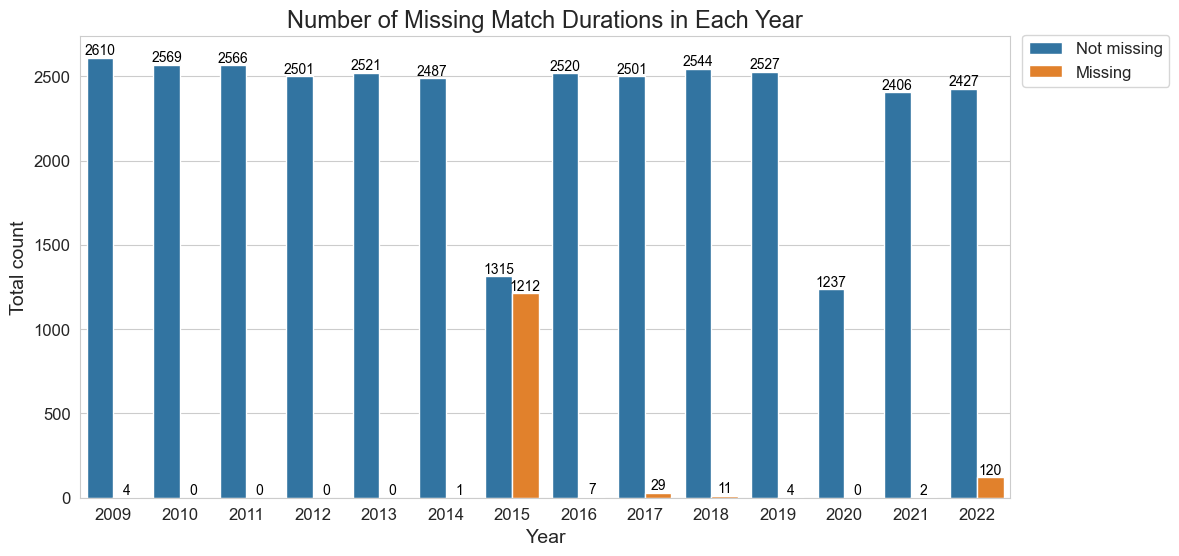

In [26]:
# Add a new column indicating whether 'minutes' is missing
df['minutes_missing'] = df['minutes'].isnull()

# Replace the True/False labels with "Missing"/"Not missing"
df['minutes_missing'] = df['minutes_missing'].replace({True: "Missing", False: "Not missing"})

# Calculate the percentage of matches per year and the percentage of missing 'minutes' per year
df_cat = pd.DataFrame(df['year'].value_counts(normalize=True) * 100)
df_cat['minutes_missing_percentage'] = df.groupby('year')['minutes_missing'].apply(lambda x: x.value_counts(normalize=True)["Missing"]*100 if "Missing" in x.value_counts(normalize=True).index else 0)

# Rename the columns
df_cat.columns = ['Year (%)', 'Minutes Missing (%)']

# Fill missing values with 0 and sort by year
df_cat.fillna(0, inplace=True)
df_cat.sort_index(inplace=True)

# Display the DataFrame
display(df_cat)

# Plot the count of matches per year, color-coded by whether 'minutes' is missing
plt.figure(figsize=(12,6))
sns.countplot(x='year', data=df, hue='minutes_missing')

# Write the count values on top of the bars
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width() / 2., p.get_height(), '{:1.0f}'.format(p.get_height()), fontsize=10, color='black', ha='center', va='bottom')

# Move the legend to top right outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.18, 1.02), fontsize=12)

# Update the labels
plt.title('Number of Missing Match Durations in Each Year', fontsize=17)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


In [27]:
### Kolmogorov-Smirnov normality test ###

# Create a copy of the DataFrame
df_copy = df.copy()

# List of numerical columns
num_cols = ['minutes', 'total_points', 'total_games', 'p1_points', 'p1_games', 'p1_rank', 'p1_rankpt']
stat_cols = ['p1_ace', 'p1_df', 'p1_svpt', 'p1_1stIn', 'p1_1stWon', 'p1_2ndWon', 'p1_SvGms', 'p1_bpSaved', 'p1_bpFaced']

# List of target variables
target_vars = ['minutes']

# Standardize the columns
for col in num_cols + stat_cols + target_vars:
    df_copy[col] = zscore(df_copy[col].dropna())

# Apply the Kolmogorov-Smirnov test to each standardized column and store the results
ks_results_standardized = []
for col in num_cols + stat_cols:
    col_data = df_copy[col].dropna() # Removing NaN values before applying the test
    ks_stat, ks_pval = kstest(col_data, 'norm')
    ks_results_standardized.append((col, ks_stat, ks_pval))

# Convert the results into a DataFrame
ks_results_standardized_df = pd.DataFrame(ks_results_standardized, columns=['Column', 'KS Statistic', 'P-value'])
display(ks_results_standardized_df)


,Column,KS Statistic,P-value
0,minutes,0.08,0.00
1,total_points,0.08,0.00
2,total_games,0.12,0.00
3,p1_points,0.07,0.00
4,p1_games,0.12,0.00
5,p1_rank,0.27,0.00
6,p1_rankpt,0.25,0.00
7,p1_ace,0.15,0.00
8,p1_df,0.16,0.00
9,p1_svpt,0.08,0.00


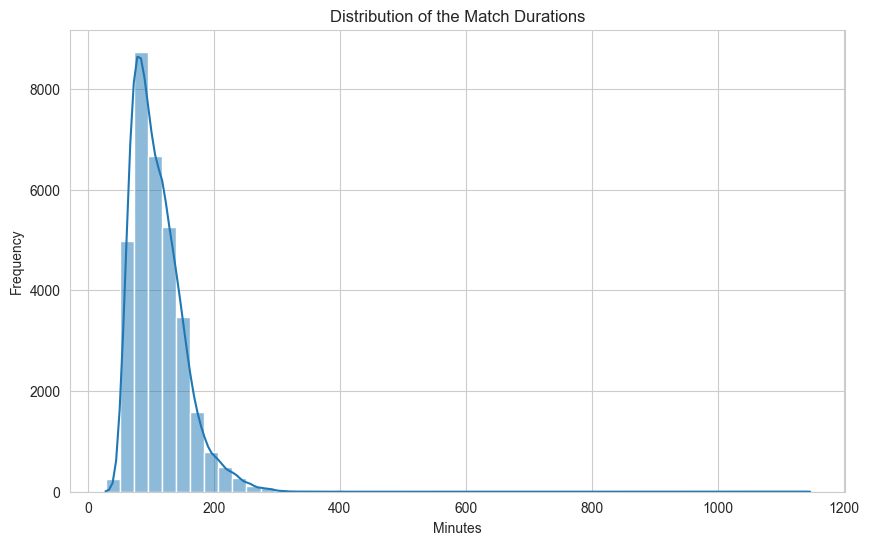

In [28]:
# Draw histogram of the minutes column
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='minutes', bins=50, kde=True)
plt.title(f'Distribution of the Match Durations')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()


In [29]:
### Spearman's correlation test ###

# Initialize a list to store the results
results = []

# Loop over each target variable
for target in target_vars:

    # Initialize the label encoder
    #label_encoder = LabelEncoder()

    # Loop over each other variable
    for var in [col for col in num_cols + stat_cols if col != target]:

        # Drop rows with missing values in the target or current variable
        temp_df = df[[target, var]].dropna()

        # Encode the ordinal categorical variable as numerical
        #encoded_var = label_encoder.fit_transform(temp_df[var])

        # Calculate Spearman's correlation
        corr, pval = spearmanr(temp_df[target], temp_df[var]) #encoded_var

        # Append the results to the list
        results.append(pd.DataFrame({'Target': [target], 'Variable': [var], 'Correlation': [corr], 'p-value': [pval]}))

# Concatenate all the results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

# Calculate the absolute value of the correlation
results_df['AbsCorrelation'] = results_df['Correlation'].abs()

# Group the results by the target variable
grouped_results = results_df.groupby('Target')

# For each group (i.e., each target variable), sort by the absolute value of the correlation and display the top X
top_related = grouped_results.apply(lambda x: x.sort_values('AbsCorrelation', ascending=False).head(5))

# Reset the index
top_related = top_related.reset_index(drop=True)

# Convert the 'Target' column to a categorical variable with the specified order
top_related['Target'] = pd.Categorical(top_related['Target'], categories=target_vars, ordered=True)

# Sort the DataFrame by the Target and Correlation columns
top_related.sort_values(['Target', 'AbsCorrelation'], ascending=[True, False], inplace=True)

# Drop the AbsCorrelation column from the top_related DataFrame
top_related = top_related.drop('AbsCorrelation', axis=1)

# Print the sorted DataFrame
print(top_related)


   Target     Variable    Correlation  p-value
0  minutes  total_points     0.95       0.00  
1  minutes       p1_svpt     0.92       0.00  
2  minutes   total_games     0.92       0.00  
3  minutes      p1_SvGms     0.91       0.00  
4  minutes     p1_points     0.90       0.00  


In [30]:
### Create a function to calculate R-squared score, remove 'minutes' values where the difference exceeds 100%, and impute missing 'minutes' values
def process_data(df, predictor, target, threshold=None, calc_r2=False, remove_outliers=False, impute_missing=False):
    # Drop rows with missing values in the relevant columns
    df_filtered = df.dropna(subset=[predictor, target])

    # Prepare the data for the linear regression model
    X = df_filtered[[predictor]]
    y = df_filtered[target]

    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Calculate the R-squared score before any changes
    if calc_r2:
        r2_before = r2_score(y, model.predict(X))
        print(f'R-squared score before: {r2_before}')

    # Calculate the estimated target values based on the predictor
    df[f'estimated_{target}'] = model.predict(df[[predictor]])

    # Calculate the difference between real and estimated target values
    df[f'{target}_difference%'] = abs((df[target] - df[f'estimated_{target}']) / df[f'estimated_{target}']) * 100

    # Remove real target values where the difference percentage exceeds the threshold
    if remove_outliers and threshold is not None:
        num_removed = df[df[f'{target}_difference%'] > threshold][target].count()
        df.loc[df[f'{target}_difference%'] > threshold, target] = np.nan
        print(f'Number of removed values: {num_removed}')

        # Re-fit the model after removing outliers
        df_filtered = df.dropna(subset=[predictor, target])
        X = df_filtered[[predictor]]
        y = df_filtered[target]
        model.fit(X, y)

        # Update the estimated target values based on the new model
        df[f'estimated_{target}'] = model.predict(df[[predictor]])
        df[f'{target}_difference%'] = abs((df[target] - df[f'estimated_{target}']) / df[f'estimated_{target}']) * 100

    # Impute missing target values using the estimated values
    if impute_missing:
        num_imputed = df[target].isna().sum()
        df.loc[df[target].isna(), target] = df.loc[df[target].isna(), f'estimated_{target}'].round(0)
        print(f'Number of imputed values: {num_imputed}')

    # Calculate the R-squared score after changes
    if (remove_outliers and threshold) or impute_missing:
        r2_after = r2_score(y, model.predict(X))
        print(f'R-squared score after: {r2_after}')

    return df


### Create a function to plot a first degree (linear) and a second degree polynomial regression model, and calculate their R-squared scores
def plot_and_score(df, x, y, title, xlabel, ylabel, order=2, figsize=(10,10), color='pastel', fontsize=15):
    # Extract the relevant columns
    df_filtered = df.dropna(subset=[x, y])
    X = df_filtered[x].values.reshape(-1, 1)
    y = df_filtered[y]

    # Create and fit the first degree polynomial regression model (linear model)
    model_linear = LinearRegression()
    model_linear.fit(X, y)

    # Predict the target values
    y_predicted_linear = model_linear.predict(X)

    # Calculate the R-squared score for the linear model
    r2_linear = r2_score(y, y_predicted_linear)
    print(f'R-squared score for linear model of order 1: {r2_linear}')

    # # Create and fit the second degree polynomial regression model
    # model_poly = make_pipeline(PolynomialFeatures(order), LinearRegression())
    # model_poly.fit(X, y)

    # # Predict the target values
    # y_predicted_poly = model_poly.predict(X)

    # # Calculate the R-squared score for the second degree polynomial model
    # r2_poly = r2_score(y, y_predicted_poly)
    # print(f'R-squared score for polynomial model of order {order}: {r2_poly}')

    # Set the size, style, and font scale of the plot
    sns.set(rc={"figure.figsize": figsize}, style='whitegrid', font_scale=fontsize/10)

    # Create a jointplot
    joint = sns.jointplot(x=x, y=y, data=df_filtered, height=sum(figsize)/2)

    # Add the linear regression line
    sns.regplot(x=x, y=y, data=df_filtered, scatter=False, ax=joint.ax_joint, color='red', label='Fitted linear regression line')
    # sns.regplot(x=x, y=y, data=df_filtered, scatter=False, ax=joint.ax_joint, color='black', label='order=1')

    # # Add the polynomial regression line
    # sns.regplot(x=x, y=y, data=df_filtered, order=order, scatter=False, ax=joint.ax_joint, color='red', label=f'order={order}')

    # Hide the marginal histograms
    joint.ax_marg_x.set_visible(False)
    joint.ax_marg_y.set_visible(False)

    # Add a legend, title, and labels
    joint.ax_joint.legend(fontsize=17) # font sizes made bigger because of thesis
    plt.title(title, fontsize=21)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    # Limit the axes
    joint.ax_joint.set_ylim([0, 1000])
    joint.ax_joint.set_xlim([0, 1210])

    plt.show()


### Create a function to plot a boxplot by year
def boxplot_by_year(df, x, y, title, xlabel, ylabel, figsize=(12,8), color='pastel'):
    # Create the figure
    plt.figure(figsize=figsize)

    # Create the boxplot
    sns.boxplot(y=y, x=x, data=df, orient='h', palette=color)

    # Add a title and labels
    plt.title(title, fontsize=15) 
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # Set the font size of the ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show the grid
    plt.grid(True)

    # Remove the top and right spines
    sns.despine()

    plt.show()


R-squared score before: 0.8778357950543269
R-squared score for linear model of order 1: 0.8778357950543269


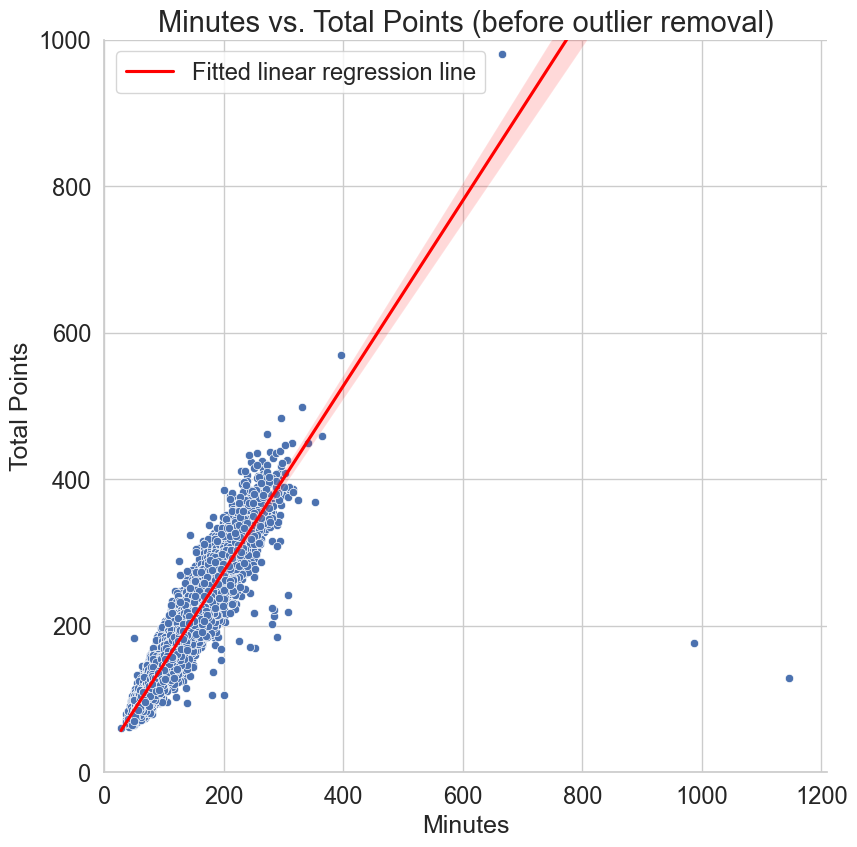

R-squared score before: 0.8778357950543269
Number of removed values: 54
R-squared score after: 0.9140233176405249
R-squared score for linear model of order 1: 0.9140233176405249


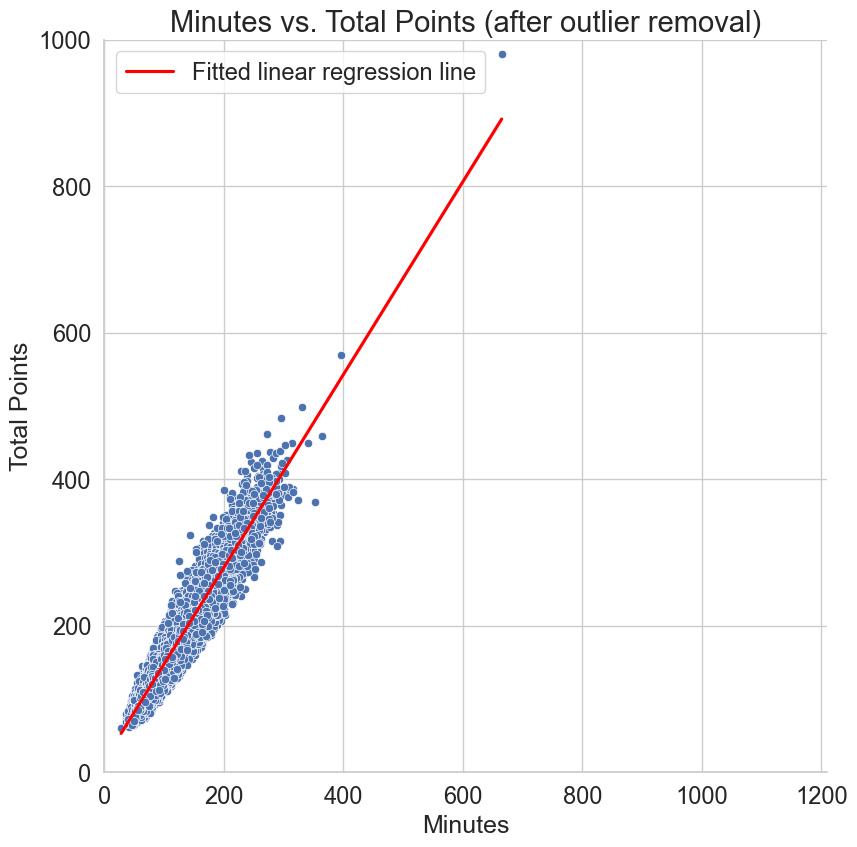

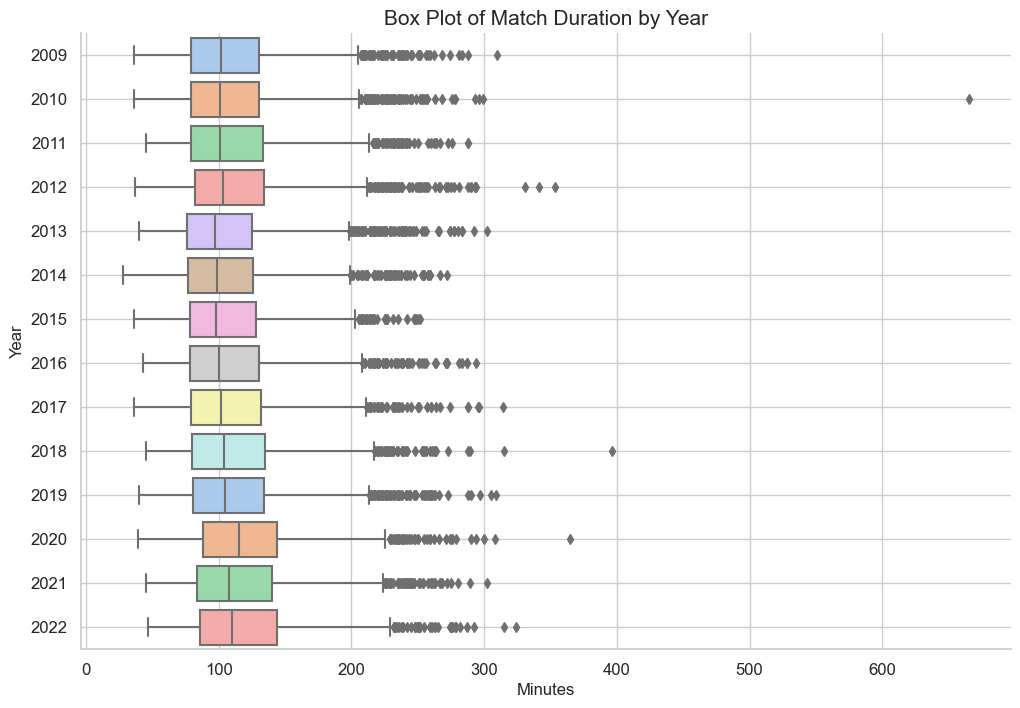

R-squared score before: 0.9140233176405249
Number of imputed values: 1444
R-squared score after: 0.9140233176405249
R-squared score for linear model of order 1: 0.9175082713517151


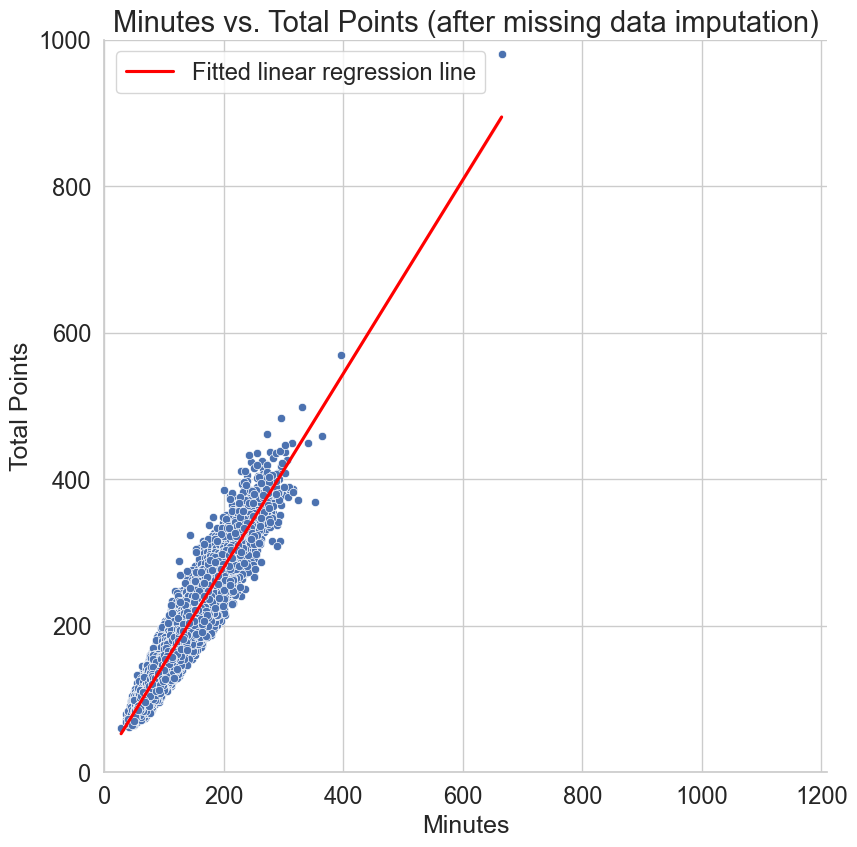

In [31]:
# Calculate R-squared score
df = process_data(df, 'total_points', 'minutes', threshold=None, calc_r2=True, remove_outliers=False, impute_missing=False)

# Use the function to plot the regression models and calculate R-squared scores
plot_and_score(df, 'minutes', 'total_points', 'Minutes vs. Total Points (before outlier removal)', 'Minutes', 'Total Points')


# Remove 'minutes' values where the difference exceeds a certain value
df = process_data(df, 'total_points', 'minutes', threshold=40, calc_r2=True, remove_outliers=True, impute_missing=False)

# Use the function to plot the regression models and calculate R-squared scores
plot_and_score(df, 'minutes', 'total_points', 'Minutes vs. Total Points (after outlier removal)', 'Minutes', 'Total Points')

# Use the function to generate the boxplot of 'year' and 'minutes'
boxplot_by_year(df, 'minutes', 'year', 'Box Plot of Match Duration by Year', 'Minutes', 'Year')


# Impute missing 'minutes' values
df = process_data(df, 'total_points', 'minutes', threshold=None, calc_r2=True, remove_outliers=False, impute_missing=True)

# Use the function to plot the regression models and calculate R-squared scores
plot_and_score(df, 'minutes', 'total_points', 'Minutes vs. Total Points (after missing data imputation)', 'Minutes', 'Total Points')


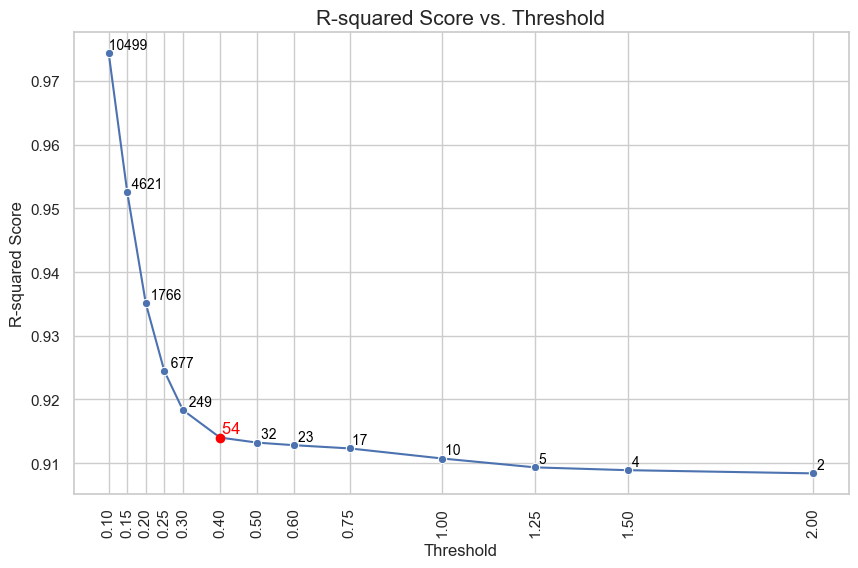

In [32]:
# R2 scores for different thresholds
r2_scores = {0.1: 0.974341, #10499 removed
             0.15: 0.952502, #4621 removed
             0.2: 0.935075, #1766 removed
             0.25: 0.924447, #677 removed
             0.3: 0.918343, #249 removed
             0.4: 0.914023, #54 removed
             0.5: 0.913226, #32 removed
             0.6: 0.912819, #23 removed
             0.75: 0.912314, #17 removed
             1.0: 0.910728, #10 removed
             1.25: 0.909337, #5 removed
             1.5: 0.908898, #4 removed
             2.0: 0.908396, #2 removed    
}

# Number of data points removed for each threshold
num_removed = {0.1: "   10499", 0.15: "   4621", 0.2: "   1766", 
               0.25: "  677", 0.3: "  249", 0.4: "54 ", 
               0.5: "32 ", 0.6: "23 ", 0.75: "17  ", 
               1.0: "10  ", 1.25: "5   ", 1.5: "4   ", 2.0: "2   "}

# Plotting the R-squared scores
plt.figure(figsize=(10,6))
sns.lineplot(x=list(r2_scores.keys()), y=list(r2_scores.values()), marker='o')
plt.xticks(list(r2_scores.keys()), rotation=90, fontsize=12)
#plt.yticks(list(r2_scores.values()), rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Annotate the graph with the number of data points removed
for threshold, score in r2_scores.items():
    annotation_fontsize = 10
    annotation_color = 'black'
    
    # Highlight the point and annotation for threshold=0.4
    if threshold == 0.4:
        plt.scatter([threshold], [score], color='red', zorder=5)
        annotation_fontsize = 12
        annotation_color = 'red'
    
    plt.annotate(f"{num_removed[threshold]}", 
                 (threshold, score), 
                 textcoords="offset points", 
                 xytext=(10,3), 
                 ha='center', 
                 fontsize=annotation_fontsize, 
                 color=annotation_color)

plt.title('R-squared Score vs. Threshold', fontsize=15)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('R-squared Score', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True)
plt.show()


In [33]:
# Drop minutes_missing, estimated_minutes, minutes_difference% columns that were created for the analysis
df.drop(columns=['minutes_missing', 'estimated_minutes', 'minutes_difference%'], inplace=True)

##### Impute Missing Odds #####

In [34]:
# Add a new column indicating whether 'p1_Max' is missing
df['odds_missing'] = df['p1_Max'].isnull()

# Print the number of missing values in 'stats_missing' column
print("Number of missing distinct matches:", df['odds_missing'].sum())

Number of missing distinct matches: 51


In [35]:
df[df['odds_missing'] == True]

,match_id,match_date,year,tourney_name,tourney_level,court,surface,draw_size,round,best_of,minutes,total_points,total_games,score,p1_won,p1_points,p2_points,p1_games,p2_games,p1_sets,p2_sets,p1_id,p2_id,p1_name,p2_name,p1_rank,p2_rank,p1_rankpt,p2_rankpt,p1_hand,p2_hand,p1_ht,p2_ht,p1_ioc,p2_ioc,p1_age,p2_age,p1_seed,p2_seed,p1_entry,p2_entry,p1_ace,p2_ace,p1_df,p2_df,p1_svpt,p2_svpt,p1_1stIn,p2_1stIn,p1_1stWon,p2_1stWon,p1_2ndWon,p2_2ndWon,p1_SvGms,p2_SvGms,p1_bpSaved,p2_bpSaved,p1_bpFaced,p2_bpFaced,p1_Max,p2_Max,p1_Avg,p2_Avg,odds_missing
392,2009-424-0014,2009-02-11,2009,San Jose,A,Indoor,Hard,32,R32,3,87.00,143.00,23,7-6(9) 6-4,1,74.00,69.00,13,10,2,0,104545,102887,John Isner,Ramon Delgado,139.00,277.00,635.00,264.00,R,R,206.00,185.00,USA,PAR,23.70,32.20,12.00,12.00,WC,LL,22.00,5.00,1.00,1.00,78.00,65.00,60.00,42.00,41.00,34.00,11.00,9.00,11.00,11.00,0.00,0.00,1.00,2.00,NaN,NaN,NaN,NaN,True
828,2009-717-0009,2009-04-07,2009,Houston,A,Outdoor,Clay,32,R32,3,139.00,221.00,33,6-7(5) 7-6(5) 6-1,0,103.00,118.00,14,19,1,2,104025,104154,Amer Delic,Paul Capdeville,148.00,87.00,552.00,902.00,R,R,196.00,190.00,BIH,CHI,26.70,26.00,12.00,12.00,LL,NaN,6.00,1.00,3.00,4.00,114.00,107.00,70.00,74.00,43.00,54.00,29.00,22.00,15.00,16.00,10.00,2.00,13.00,3.00,NaN,NaN,NaN,NaN,True
1061,2009-5053-0008,2009-05-05,2009,Belgrade,A,Outdoor,Clay,28,R32,3,95.00,150.00,24,2-6 6-2 6-2,0,67.00,83.00,10,14,1,2,103103,104019,Dominik Hrbaty,Kristof Vliegen,160.00,105.00,477.00,795.00,R,R,183.00,193.00,SVK,BEL,31.30,26.80,10.00,10.00,Q,NaN,1.00,6.00,4.00,1.00,86.00,64.00,57.00,37.00,36.00,29.00,11.00,15.00,12.00,12.00,4.00,1.00,8.00,3.00,NaN,NaN,NaN,NaN,True
1062,2009-5053-0009,2009-05-05,2009,Belgrade,A,Outdoor,Clay,28,R32,3,100.00,129.00,21,6-3 7-5,0,57.00,72.00,8,13,0,2,105440,103997,Arsenije Zlatanovic,Lukasz Kubot,1421.00,179.00,4.00,423.00,R,R,193.00,190.00,SRB,POL,19.40,26.90,10.00,10.00,WC,LL,7.00,3.00,2.00,3.00,67.00,62.00,36.00,36.00,22.00,22.00,13.00,18.00,11.00,10.00,2.00,1.00,7.00,3.00,NaN,NaN,NaN,NaN,True
1063,2009-5053-0010,2009-05-05,2009,Belgrade,A,Outdoor,Clay,28,R32,3,82.00,109.00,17,6-1 6-4,0,45.00,64.00,5,12,0,2,103490,103096,Santiago Ventura,Arnaud Clement,117.00,57.00,720.00,1144.00,R,R,183.00,173.00,ESP,FRA,29.30,31.30,10.00,7.00,Q,NaN,3.00,1.00,2.00,1.00,54.00,55.00,42.00,45.00,20.00,30.00,4.00,4.00,8.00,9.00,3.00,4.00,8.00,6.00,NaN,NaN,NaN,NaN,True
1067,2009-5053-0011,2009-05-06,2009,Belgrade,A,Outdoor,Clay,28,R32,3,126.00,195.00,23,1-6 6-3 6-1,0,94.00,101.00,10,13,1,2,104571,104262,Marcos Baghdatis,Flavio Cipolla,87.00,122.00,860.00,668.00,R,R,183.00,173.00,CYP,ITA,23.80,25.50,10.00,10.00,WC,Q,3.00,0.00,1.00,4.00,101.00,94.00,77.00,76.00,40.00,42.00,12.00,10.00,11.00,12.00,15.00,14.00,20.00,18.00,NaN,NaN,NaN,NaN,True
1125,2009-1536-0024,2009-05-11,2009,Madrid Masters,M,Outdoor,Clay,56,R64,3,71.00,104.00,18,6-4 6-2,1,60.00,44.00,12,6,2,0,104417,103868,Robin Soderling,Ivan Navarro,23.00,84.00,1880.00,891.00,R,R,193.00,183.00,SWE,ESP,24.70,27.50,20.00,20.00,NaN,LL,6.00,5.00,2.00,3.00,55.00,49.00,29.00,30.00,22.00,20.00,15.00,6.00,9.00,9.00,2.00,0.00,3.00,4.00,NaN,NaN,NaN,NaN,True
1173,2009-306-0007,2009-05-19,2009,Kitzbuhel,A,Outdoor,Clay,32,R32,3,89.00,112.00,19,6-4 6-3,0,49.00,63.00,7,12,0,2,104339,103105,Mario Ancic,Ruben Ramirez Hidalgo,38.00,131.00,1435.00,604.00,R,R,196.00,183.00,CRO,ESP,25.10,31.30,12.00,12.00,Q,LL,4.00,2.00,1.00,3.00,61.00,51.00,38.00,30.00,25.00,26.00,12.00,13.00,10.00,9.00,3.00,4.00,6.00,4.00,NaN,NaN,NaN,NaN,True
1227,2009-520-0059,2009-05-25,2009,Roland Garros,G,Outdoor,Clay,128,R128,5,115.00,176.00,30,6-2 7-6(10) 6-3,1,98.00,78.00,19,11,3,0,104871,103999,Jeremy Chardy,Thiago Alves,39.00,117.00,1394.00,712.00,R,R,188.00,178.00,FRA,BRA,22.20,27.00,48.00,48.00,NaN,LL,21.00,1.00,5.00,4.00,90.00,86.00,58.00,59.00,47.00,36.00,16.00,15.00,15.00,14.00,3.00,4.00,6.00,10.00,NaN,NaN,NaN,NaN,True
1360,2009-311-0032,2009-06-10,2009,Queen's Club,A,Outdoor,Grass,56,R32,3,119.00,170.00,26,7-6(6) 7-6(8),1,91.00,79.00,14,

In [36]:
# Create necessary columns for the analysis
df['p1_points_ratio'] = df['p1_points'] / (df['p1_points'] + df['p2_points'])
df['p2_points_ratio'] = df['p2_points'] / (df['p1_points'] + df['p2_points'])
df['p1_games_ratio'] = df['p1_games'] / (df['p1_games'] + df['p2_games'])
df['p2_games_ratio'] = df['p2_games'] / (df['p1_games'] + df['p2_games'])
df['p1_sets_ratio'] = df['p1_sets'] / (df['p1_sets'] + df['p2_sets'])
df['p2_sets_ratio'] = df['p2_sets'] / (df['p1_sets'] + df['p2_sets'])
df['diff_rank'] = df['p1_rank'] - df['p2_rank']
df['diff_rank_log'] = np.sign(df['diff_rank']) * np.log10(np.abs(df['diff_rank']) + 1)
df['diff_rankpt'] = df['p1_rankpt'] - df['p2_rankpt']
df['diff_rankpt_log'] = np.sign(df['diff_rankpt']) * np.log10(np.abs(df['diff_rankpt']) + 1)

In [37]:
### Kolmogorov-Smirnov normality test ###

# Create a copy of the DataFrame
df_copy = df.copy()

# List of numerical columns
num_cols = ['p1_won', 'p1_points_ratio', 'p2_points_ratio', 'p1_games_ratio', 'p2_games_ratio', 
            'p1_sets_ratio', 'p2_sets_ratio', 'diff_rank', 'diff_rank_log', 'diff_rankpt', 'diff_rankpt_log']
stat_cols = ['p1_ace', 'p2_ace', 'p1_df', 'p2_df', 'p1_svpt', 'p2_svpt', 'p1_1stIn', 'p2_1stIn', 'p1_1stWon', 'p2_1stWon', 
             'p1_2ndWon', 'p2_2ndWon', 'p1_SvGms', 'p2_SvGms', 'p1_bpSaved', 'p2_bpSaved', 'p1_bpFaced', 'p2_bpFaced']

# List of target variables
target_vars = ['p1_Max', 'p2_Max', 'p1_Avg', 'p2_Avg']

# Standardize the columns
for col in num_cols + stat_cols + target_vars:
    df_copy[col] = zscore(df_copy[col].dropna())

# Apply the Kolmogorov-Smirnov test to each standardized column and store the results
ks_results_standardized = []
for col in num_cols + stat_cols:
    col_data = df_copy[col].dropna() # Removing NaN values before applying the test
    ks_stat, ks_pval = kstest(col_data, 'norm')
    ks_results_standardized.append((col, ks_stat, ks_pval))

# Convert the results into a DataFrame
ks_results_standardized_df = pd.DataFrame(ks_results_standardized, columns=['Column', 'KS Statistic', 'P-value'])
display(ks_results_standardized_df)


,Column,KS Statistic,P-value
0,p1_won,0.34,0.00
1,p1_points_ratio,0.02,0.00
2,p2_points_ratio,0.02,0.00
3,p1_games_ratio,0.04,0.00
4,p2_games_ratio,0.04,0.00
5,p1_sets_ratio,0.20,0.00
6,p2_sets_ratio,0.20,0.00
7,diff_rank,0.20,0.00
8,diff_rank_log,0.17,0.00
9,diff_rankpt,0.17,0.00


In [38]:
### Spearman's correlation test ###

# Initialize a list to store the results
results = []

# Loop over each target variable
for target in target_vars:

    # Initialize the label encoder
    #label_encoder = LabelEncoder()

    # Loop over each other variable
    for var in [col for col in num_cols + stat_cols if col != target]:

        # Drop rows with missing values in the target or current variable
        temp_df = df[[target, var]].dropna()

        # Encode the ordinal categorical variable as numerical
        #encoded_var = label_encoder.fit_transform(temp_df[var])

        # Calculate Spearman's correlation
        corr, pval = spearmanr(temp_df[target], temp_df[var]) #encoded_var

        # Append the results to the list
        results.append(pd.DataFrame({'Target': [target], 'Variable': [var], 'Correlation': [corr], 'p-value': [pval]}))

# Concatenate all the results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

# Calculate the absolute value of the correlation
results_df['AbsCorrelation'] = results_df['Correlation'].abs()

# Group the results by the target variable
grouped_results = results_df.groupby('Target')

# For each group (i.e., each target variable), sort by the absolute value of the correlation and display the top X
top_related = grouped_results.apply(lambda x: x.sort_values('AbsCorrelation', ascending=False).head(10))

# Reset the index
top_related = top_related.reset_index(drop=True)

# Convert the 'Target' column to a categorical variable with the specified order
top_related['Target'] = pd.Categorical(top_related['Target'], categories=target_vars, ordered=True)

# Sort the DataFrame by the Target and Correlation columns
top_related.sort_values(['Target', 'AbsCorrelation'], ascending=[True, False], inplace=True)

# Drop the AbsCorrelation column from the top_related DataFrame
top_related = top_related.drop('AbsCorrelation', axis=1)

# Print the sorted DataFrame
print(top_related)

    Target     Variable      Correlation  p-value
10  p1_Max      diff_rankpt    -0.81       0.00  
11  p1_Max  diff_rankpt_log    -0.81       0.00  
12  p1_Max        diff_rank     0.73       0.00  
13  p1_Max    diff_rank_log     0.73       0.00  
14  p1_Max  p1_points_ratio    -0.55       0.00  
15  p1_Max  p2_points_ratio     0.55       0.00  
16  p1_Max   p1_games_ratio    -0.53       0.00  
17  p1_Max   p2_games_ratio     0.53       0.00  
18  p1_Max    p1_sets_ratio    -0.49       0.00  
19  p1_Max    p2_sets_ratio     0.49       0.00  
30  p2_Max      diff_rankpt     0.81       0.00  
31  p2_Max  diff_rankpt_log     0.81       0.00  
32  p2_Max        diff_rank    -0.73       0.00  
33  p2_Max    diff_rank_log    -0.73       0.00  
34  p2_Max  p1_points_ratio     0.55       0.00  
35  p2_Max  p2_points_ratio    -0.55       0.00  
36  p2_Max   p1_games_ratio     0.53       0.00  
37  p2_Max   p2_games_ratio    -0.53       0.00  
38  p2_Max    p1_sets_ratio     0.49       0.00  


Visualizing and scoring p1_Max and diff_rankpt:
R-squared score for linear model of order 1: 0.35992993873991574
R-squared score for polynomial model of order 2: 0.41668769405270933


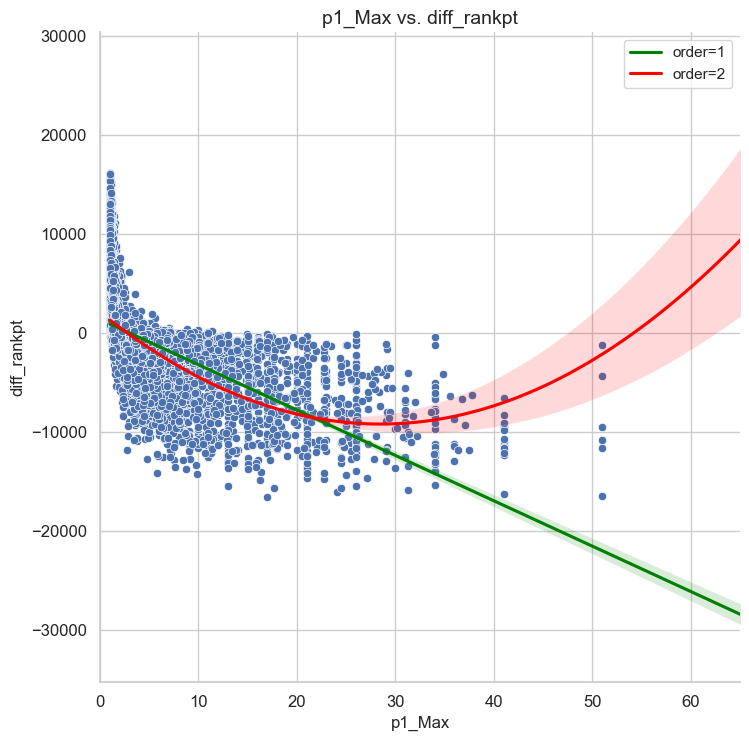

Visualizing and scoring p1_Max and diff_rank:
R-squared score for linear model of order 1: 0.08436884745548867
R-squared score for polynomial model of order 2: 0.1241070015723531


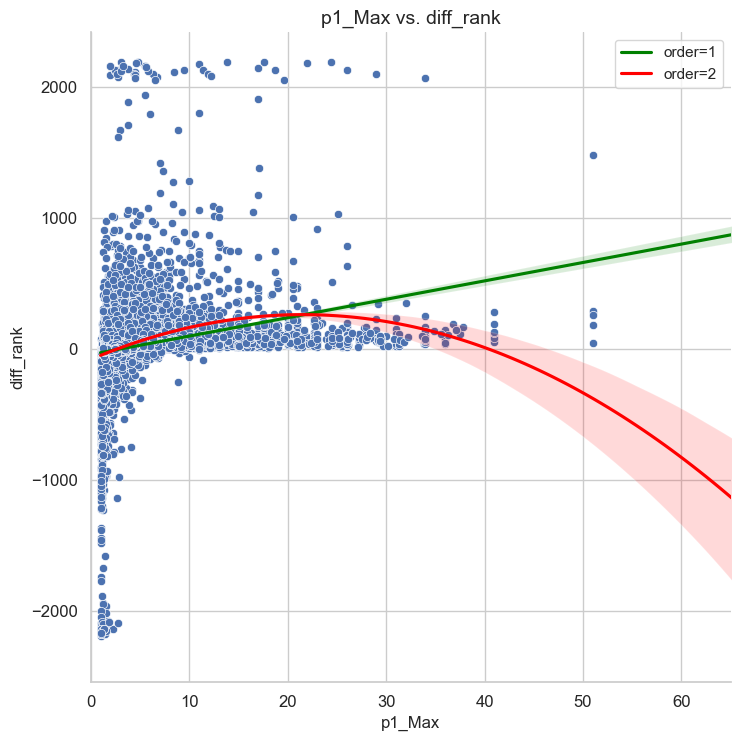

Visualizing and scoring p2_Max and diff_rankpt:
R-squared score for linear model of order 1: 0.3480682607684005
R-squared score for polynomial model of order 2: 0.4009061574517976


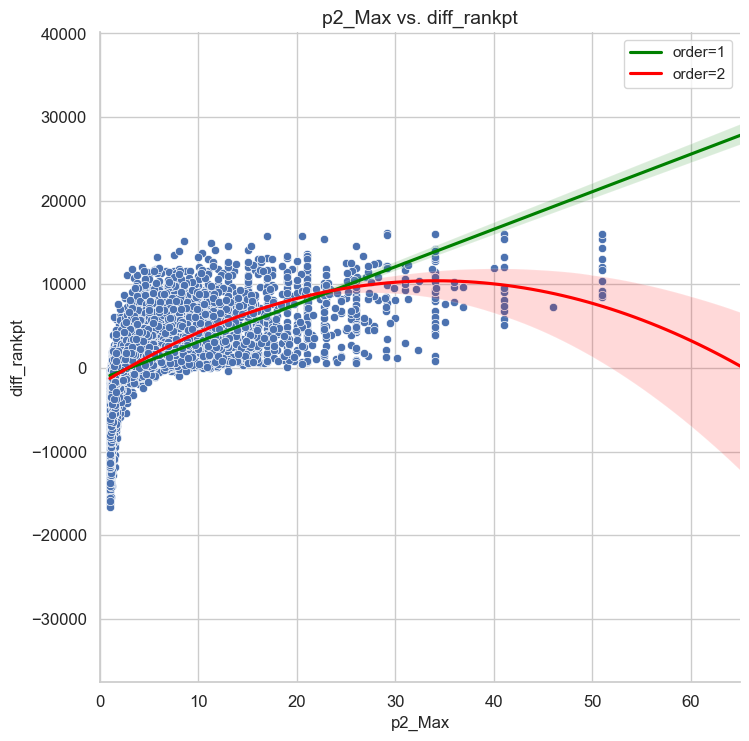

Visualizing and scoring p2_Max and diff_rank:
R-squared score for linear model of order 1: 0.0929853594839326
R-squared score for polynomial model of order 2: 0.130343821302068


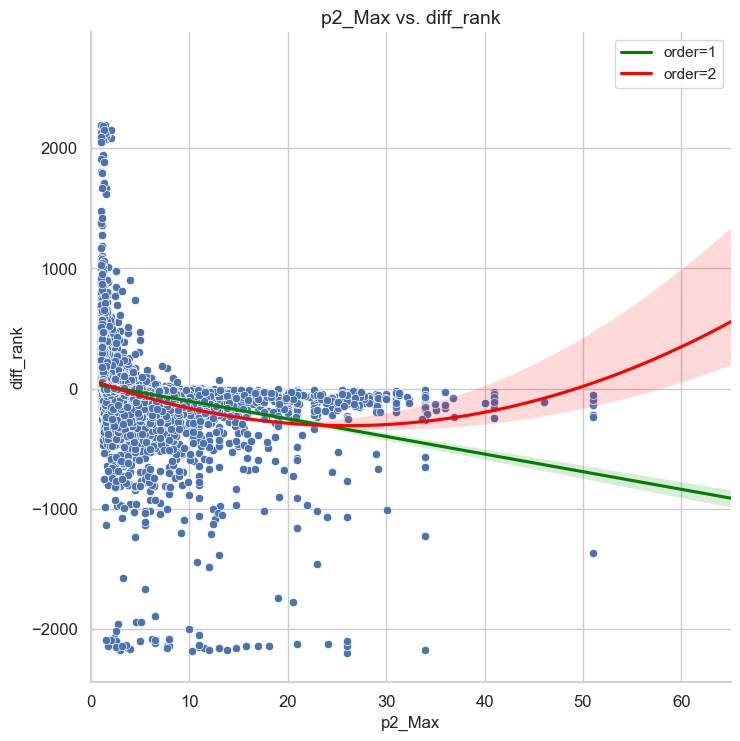

Visualizing and scoring p1_Avg and diff_rankpt:
R-squared score for linear model of order 1: 0.38271894799917794
R-squared score for polynomial model of order 2: 0.4342713853795911


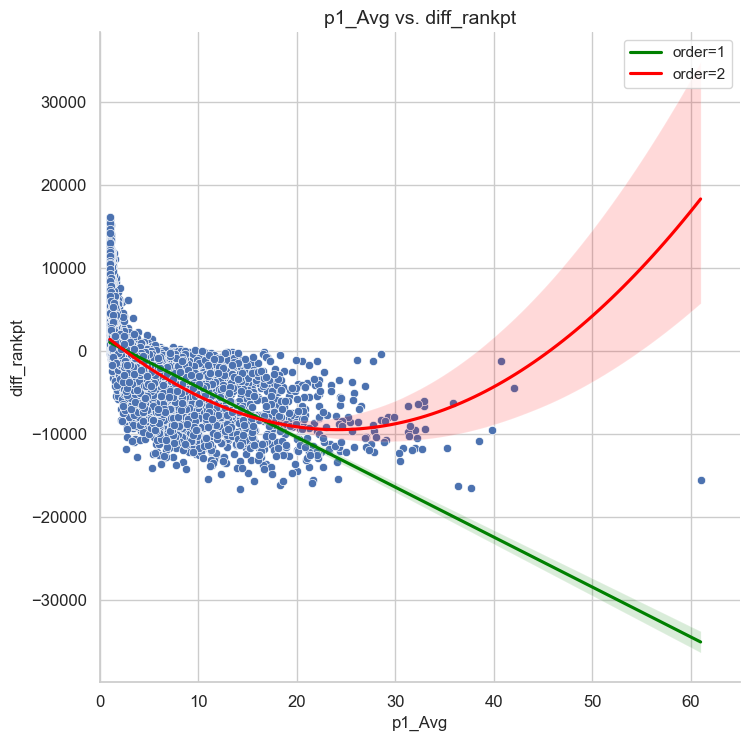

Visualizing and scoring p1_Avg and diff_rank:
R-squared score for linear model of order 1: 0.09516949584513945
R-squared score for polynomial model of order 2: 0.13038983736904908


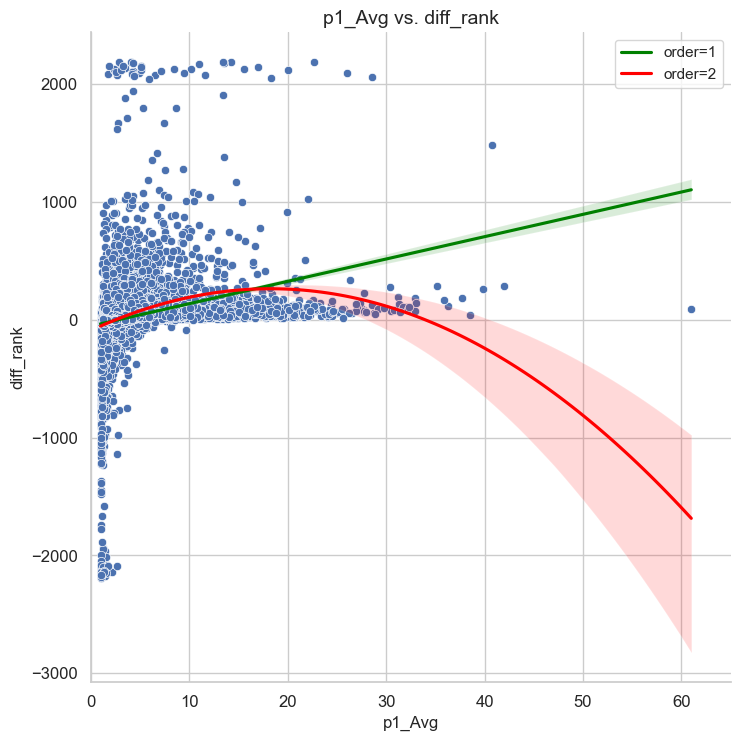

Visualizing and scoring p2_Avg and diff_rankpt:
R-squared score for linear model of order 1: 0.37378628884698517
R-squared score for polynomial model of order 2: 0.4212210213761922


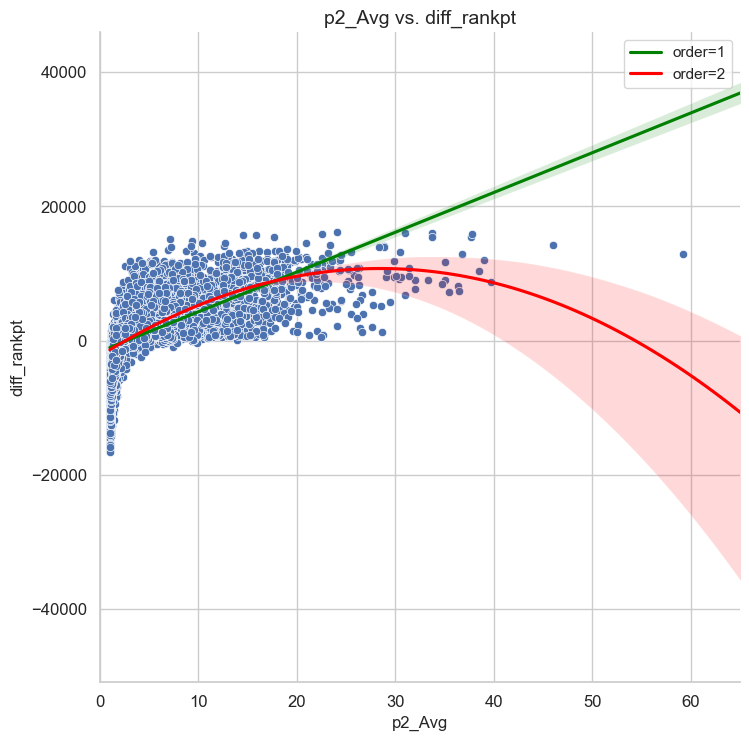

Visualizing and scoring p2_Avg and diff_rank:
R-squared score for linear model of order 1: 0.10289679178189926
R-squared score for polynomial model of order 2: 0.1380677558563107


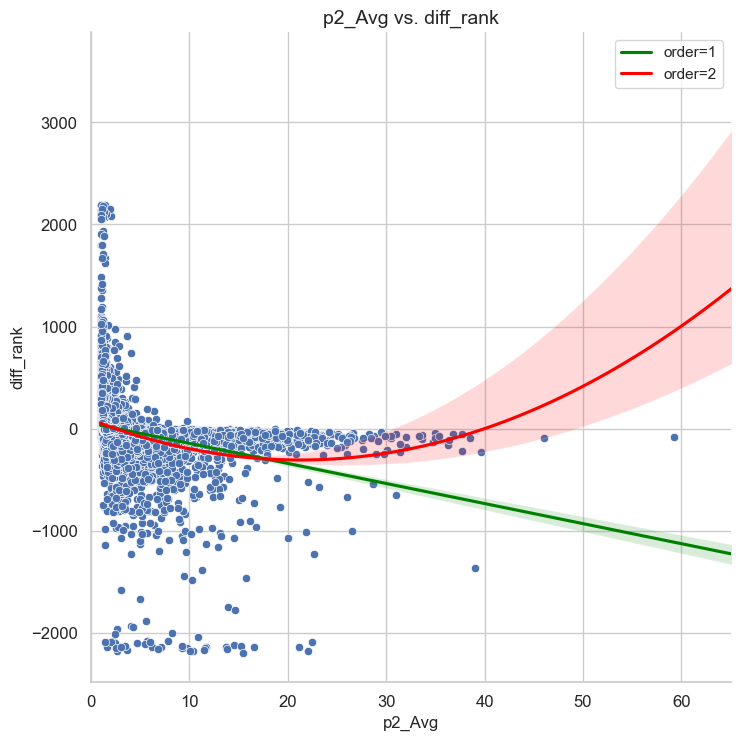

In [39]:
### LR visualization ###
def plot_and_score(df, x, y, title, xlabel, ylabel, order=2, figsize=(12,6), color='pastel', fontsize=15, ticksize=12):
    # Extract the relevant columns
    df_filtered = df.dropna(subset=[x, y])
    X = df_filtered[x].values.reshape(-1, 1)
    y = df_filtered[y]

    # Create and fit the first degree polynomial regression model (linear model)
    model_linear = LinearRegression()
    model_linear.fit(X, y)

    # Predict the target values
    y_predicted_linear = model_linear.predict(X)

    # Calculate the R-squared score for the linear model
    r2_linear = r2_score(y, y_predicted_linear)
    print(f'R-squared score for linear model of order 1: {r2_linear}')

    # Create and fit the second degree polynomial regression model
    model_poly = make_pipeline(PolynomialFeatures(order), LinearRegression())
    model_poly.fit(X, y)

    # Predict the target values
    y_predicted_poly = model_poly.predict(X)

    # Calculate the R-squared score for the second degree polynomial model
    r2_poly = r2_score(y, y_predicted_poly)
    print(f'R-squared score for polynomial model of order {order}: {r2_poly}')

    # Set the size, style, and font scale of the plot
    sns.set(rc={"figure.figsize": figsize}, style='whitegrid', font_scale=fontsize/10)

    # Create a jointplot
    joint = sns.jointplot(x=x, y=y, data=df_filtered, height=sum(figsize)/2)

    # Remove the marginal histograms
    joint.ax_marg_x.set_visible(False)
    joint.ax_marg_y.set_visible(False)

    # Add the linear regression line
    sns.regplot(x=x, y=y, data=df_filtered, scatter=False, ax=joint.ax_joint, color='green', label='order=1')

    # Add the polynomial regression line
    sns.regplot(x=x, y=y, data=df_filtered, order=order, scatter=False, ax=joint.ax_joint, color='red', label=f'order={order}')

    # Add a legend, title, and labels
    joint.ax_joint.legend(fontsize=fontsize-4)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(0, 65) # for p1_Avg vs. diff_rankpt in the thesis
    plt.grid(True)
    plt.show()

# List of variables
stat_cols = ['p1_Max', 'p2_Max', 'p1_Avg', 'p2_Avg']
num_cols = ['diff_rankpt', 'diff_rank']

# Loop over each pair of stat_cols and num_cols
for stat_col in stat_cols:
    for num_col in num_cols:
        print(f"Visualizing and scoring {stat_col} and {num_col}:")
        plot_and_score(df, stat_col, num_col, f"{stat_col} vs. {num_col}", stat_col, num_col)


R-squared score for linear model of order 1: 0.38271894799917794
R-squared score for polynomial model of order 2: 0.4342713853795911


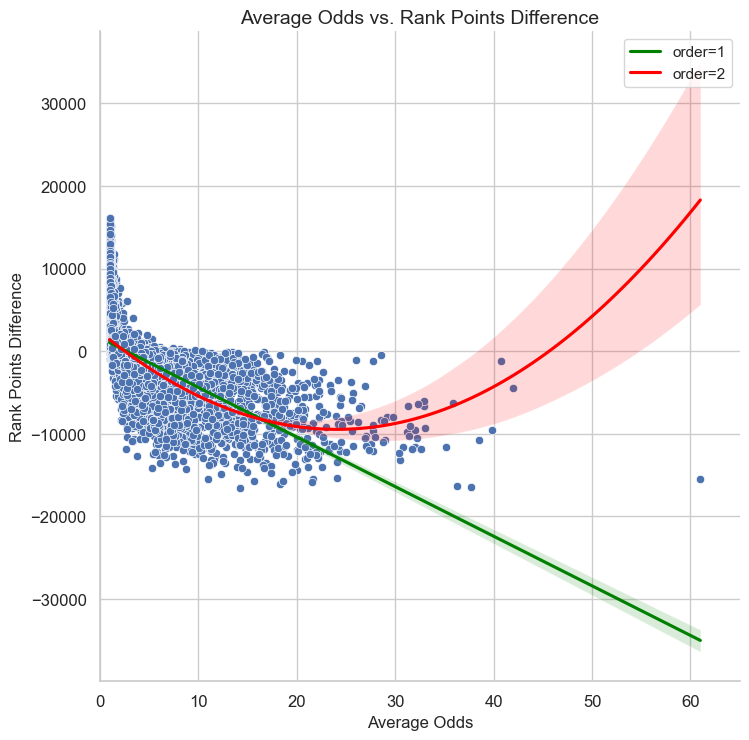

In [40]:
# Visualization for the thesis
plot_and_score(df, 'p1_Avg', 'diff_rankpt', f"Average Odds vs. Rank Points Difference", 'Average Odds', 'Rank Points Difference')

In [41]:
### Optimal n_neighbors calculation ###
def impute_knn_std(df, predictors, target, n_neighbors_list):
    scaler = StandardScaler()
    df_scaled = df[predictors + [target]].copy()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)
    knn_imputer = KNNImputer(n_neighbors=n_neighbors_list)
    df_imputed_scaled = pd.DataFrame(knn_imputer.fit_transform(df_scaled), columns=df_scaled.columns)
    df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed_scaled), columns=df_scaled.columns)
    #num_imputed = df[target].isna().sum()
    #print(f'Number of imputed values: {num_imputed}')
    df[target] = df_imputed[target]
    return df

def evaluate_imputation(df, predictors, target, n_neighbors_list):
    # Randomly mask 20% of known target values
    mask_idx = df[target].dropna().sample(frac=0.2).index
    masked_values = df.loc[mask_idx, target].copy()
    df.loc[mask_idx, target] = np.nan
    
    # Initialize dictionary to store MSE for each n_neighbors
    mse_scores = {}
    
    for n_neighbors in n_neighbors_list:
        # Perform KNN imputation
        df_imputed = impute_knn_std(df.copy(), predictors, target, n_neighbors)
        
        # Calculate MSE between imputed and original values
        mse = mean_squared_error(masked_values, df_imputed.loc[mask_idx, target])
        mse_scores[n_neighbors] = mse
        
    return mse_scores

# Seed for reproducibility
np.random.seed(42)

# Initialize list of n_neighbors to test
n_neighbors_list = [1, 2, 3, 5, 7, 10, 15, 20]

# Initialize dictionary to store MSE for each target variable
overall_mse_scores = {}

# Dictionary of target variables and corresponding predictor variables for KNN imputation
target_vars_knn = {
    #'p1_Max': ['diff_rankpt', 'diff_rank', 'p1_points_ratio'],
    #'p2_Max': ['diff_rankpt', 'diff_rank', 'p1_points_ratio'],
    'p1_Avg': ['diff_rankpt', 'diff_rank', 'p1_points_ratio'],
    'p2_Avg': ['diff_rankpt', 'diff_rank', 'p1_points_ratio']
}

# Loop over each target variable
for target, predictors in target_vars_knn.items():
    print(f"Evaluating imputation for target variable {target}:")
    mse_scores = evaluate_imputation(df.copy(), predictors, target, n_neighbors_list)
    overall_mse_scores[target] = mse_scores
    print(f"MSE scores: {mse_scores}")


Evaluating imputation for target variable p1_Avg:
MSE scores: {1: 5.059804871701767, 2: 3.8497614894962373, 3: 3.306098699553298, 5: 2.993333136800556, 7: 2.8985429999495285, 10: 2.798095364540976, 15: 2.6787185738177084, 20: 2.676699725761215}
Evaluating imputation for target variable p2_Avg:
MSE scores: {1: 4.959509118866958, 2: 3.8727717622068436, 3: 3.495980001981596, 5: 3.137384782565868, 7: 3.046925344583673, 10: 2.934852991938728, 15: 2.901690611773577, 20: 2.908225928192066}


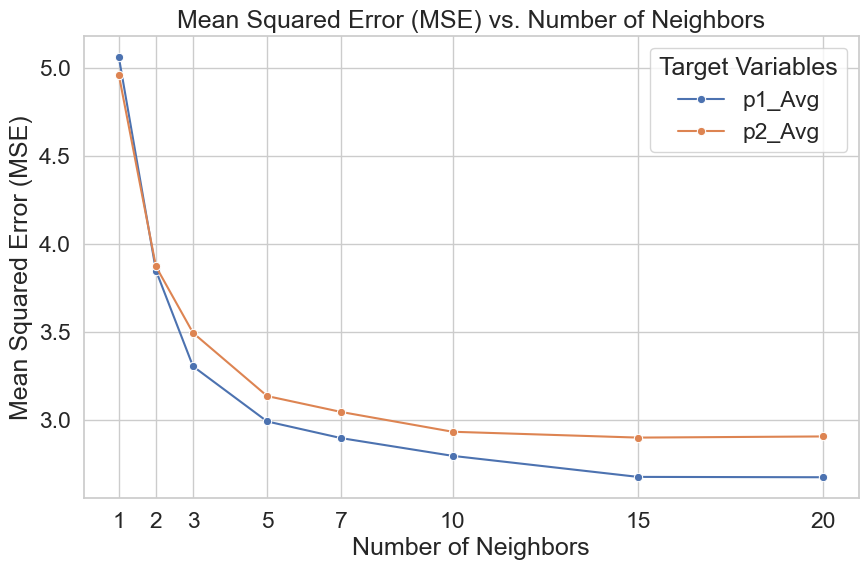

In [42]:
# Plot the MSE scores for each target variable
plt.figure(figsize=(10, 6))
for target, mse_scores in overall_mse_scores.items():
    sns.lineplot(x=list(mse_scores.keys()), y=list(mse_scores.values()), label=target, marker='o')

plt.xticks(list(overall_mse_scores['p1_Avg'].keys()))
plt.title('Mean Squared Error (MSE) vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(title='Target Variables')
plt.grid(True)
plt.show()


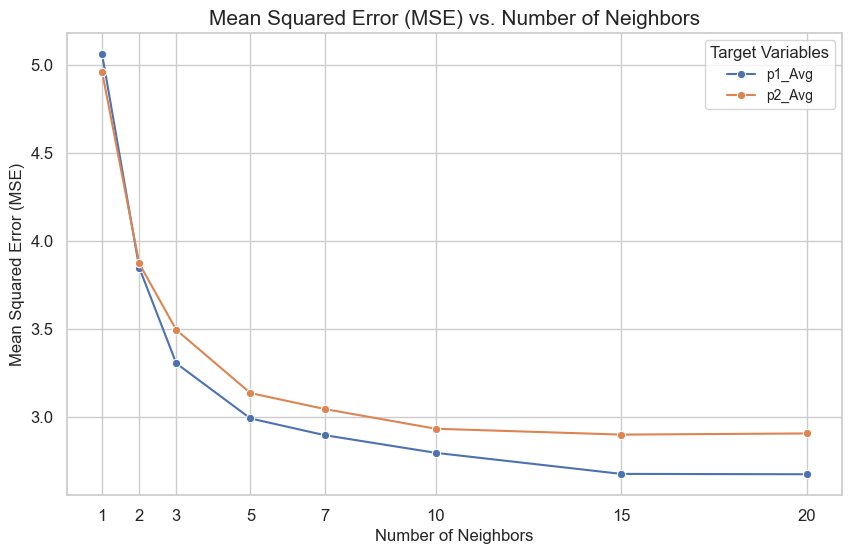

In [43]:
# Plot the MSE scores for each target variable
plt.figure(figsize=(10, 6))
for target, mse_scores in overall_mse_scores.items():
    sns.lineplot(x=list(mse_scores.keys()), y=list(mse_scores.values()), label=target, marker='o')

plt.xticks(list(overall_mse_scores['p1_Avg'].keys()), fontsize=12)
plt.yticks(fontsize=12)
plt.title('Mean Squared Error (MSE) vs. Number of Neighbors', fontsize=15)
plt.xlabel('Number of Neighbors', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.legend(title='Target Variables', title_fontsize='12', fontsize='10')  # Adjusted as per common practice for legend
plt.grid(True)
plt.show()

In [44]:
### KNN imputation with standardization ###
def impute_knn_std(df, predictors, target):
    scaler = StandardScaler()
    df_scaled = df[predictors + [target]].copy()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)
    knn_imputer = KNNImputer(n_neighbors=5)
    df_imputed_scaled = pd.DataFrame(knn_imputer.fit_transform(df_scaled), columns=df_scaled.columns)
    df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed_scaled), columns=df_scaled.columns)
    num_imputed = df[target].isna().sum()
    df[target] = df_imputed[target]
    print(f'Number of imputed values: {num_imputed}')
    return df

# Dictionary of target variables and corresponding predictor variables for KNN imputation
target_vars_knn = {
    'p1_Max': ['diff_rankpt', 'diff_rank', 'p1_points_ratio'],
    'p2_Max': ['diff_rankpt', 'diff_rank', 'p1_points_ratio'],
    'p1_Avg': ['diff_rankpt', 'diff_rank', 'p1_points_ratio'],
    'p2_Avg': ['diff_rankpt', 'diff_rank', 'p1_points_ratio']
}

# Apply KNN imputation
for target, predictors in target_vars_knn.items():
    print(f"Processing for target variable {target}:")
    df = impute_knn_std(df, predictors, target)
    

Processing for target variable p1_Max:
Number of imputed values: 51
Processing for target variable p2_Max:


Number of imputed values: 51
Processing for target variable p1_Avg:
Number of imputed values: 51
Processing for target variable p2_Avg:
Number of imputed values: 51


In [45]:
# Drop columns that were created for the analysis
df.drop(columns=['odds_missing', 'p1_points_ratio', 'p2_points_ratio', 'p1_sets_ratio', 'p2_sets_ratio', 'p1_games_ratio', 'p2_games_ratio', 
                 'diff_rank', 'diff_rank_log', 'diff_rankpt', 'diff_rankpt_log'], inplace=True)

##### Final Steps #####

In [46]:
# Print missing values in each column
display(pd.DataFrame(df.isnull().sum(), columns=['Missing']).sort_values(by='Missing', ascending=False))

,Missing
p1_entry,27718
p2_entry,27471
match_id,0
p1_1stIn,0
p2_ioc,0
p1_age,0
p2_age,0
p1_seed,0
p2_seed,0
p1_ace,0


In [47]:
# Export dataset to excel
df.to_excel('_data/_matches_list_v4.xlsx', index=False)